# Custom TTNet Implementation

## Setup

### Imports

In [40]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import utils as vutils

### GPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(0)))

# Turns on cuDNN Autotuner
torch.backends.cudnn.benchmark = True

Device: cuda:0
GPU: NVIDIA GeForce RTX 2080 Ti


### TTNet Params

In [3]:
# Folder paths
dataset_base_path = './Dataset/images'
savePath_base = "./Trained_Models/"
savePath = savePath_base+"TTNet.pth"
outputPath = "./Results/TTNet_Results/"

# Create folders if they dont exist
if not os.path.exists(outputPath): os.makedirs(outputPath)
if not os.path.exists(savePath_base): os.makedirs(savePath_base)

# Train/Test/Validation split
train_list = [f"{x:02}" for x in range(1,25)]   # "01" to "24"
test_list = [f"{x:02}" for x in range(25,28)]   # "25" to "27"
val_list = [f"{x:02}" for x in range(28,31)]    # "28" to "30"

# Training parameters
train_batch = 8
val_batch = 8
test_batch = 8
num_workers = 16
learning_rate = 1e-4
shuffle_data = True
eps = 1e-4
sigma = 1
event_num = 5 # 0: Nothing, 1: Flying, 2: Bounce, 3: Racket Contact, 4: Net Contact

# Img resolution in dataset
data_width = 1920
data_height = 1080 
# The size the images are downscaled to when being fed to the model
TTN_width=640
TTN_height=320

seed=42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Datset

In [4]:
# TODO This entire section probably needs a rewrite
transform = transforms.Compose([
  transforms.Resize((TTN_height,TTN_width)),
  transforms.ToTensor(),                 
])


def default_loader(img_path):
  img_tensor = transform(Image.open(img_path))
  return img_tensor

def getOutputArr(path,w=TTN_width,h=TTN_height):
  seg_img = cv.imread(path)
  seg_img = cv.resize(seg_img, (TTN_width , TTN_height ))
  seg_img = cv.cvtColor(seg_img,cv.COLOR_BGR2RGB)
  seg_img = seg_img.transpose(2,0,1).astype(float)
  seg_img[seg_img<75]=0
  seg_img[seg_img>75]=1
  return seg_img

def smooth_event(events,event_num):
  event_idx = event_num
  is_found = False
  for i in range((len(events)+1)//2):
    middle_index =  (len(events))//2
    if((int(events[middle_index+i])==event_num or int(events[middle_index-i])==event_num) and not is_found):
      event_idx = i
      is_found = True
  n = event_idx
  prob = np.cos(n * np.pi / 8)
  if(prob<0.01):
    return 0
  else:
    return prob

### Training

In [5]:
class train_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(train_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Test

In [6]:
class test_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(test_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

        # Get frame window image paths
        window_path = []
        middle_index = frame_no-self.window_size+(self.window_size+1)//2
        for window_frame in range(self.window_size):
          window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
        self.window_paths.append(window_path)

        # Downscaling ball xy coords into lower resolution(?)
        x_downscale = self.ball_x[middle_index]/data_width*TTN_width
        y_downscale = self.ball_y[middle_index]/data_height*TTN_height
        self.xy_downscale.append([x_downscale, y_downscale])

        # Smooth events
        event_prob = torch.zeros((event_num))
        for i in range(event_num):
          event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
        self.event_probs.append(event_prob) 

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]

    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Validation

In [7]:
class val_data_loader():
  def __init__(self, loader=default_loader, window_size=9):
    self.window_size = window_size
    self.loader = loader
    self.img_paths = []
    self.ball_x = []
    self.ball_y = []
    self.event = []
    self.window_paths = []
    self.xy_downscale = []
    self.event_probs = []

    for _,game in enumerate(val_list):
      # Read and store annotation information
      dir = dataset_base_path+"/"+game
      annotation_path = dir + f"/Annotation.csv"
      self.annotation = pd.read_csv(annotation_path)
      self.img_paths = np.asarray(self.annotation.iloc[:, 0])
      self.ball_x = np.asarray(self.annotation.iloc[:, 1])
      self.ball_y = np.asarray(self.annotation.iloc[:, 2])
      self.event = np.asarray(self.annotation.iloc[:, 3])

      for frame_no, _ in enumerate(self.img_paths): 
        # Skip indices where it is not possible to make a frame window
        if not (window_size-1 < frame_no <= len(self.img_paths)-1):
          continue

      # Get frame window image paths
      window_path = []
      middle_index = frame_no-self.window_size+(self.window_size+1)//2
      for window_frame in range(self.window_size):
        window_path.append(dir+'/'+self.img_paths[(frame_no+1)-self.window_size+window_frame])
      self.window_paths.append(window_path)

      # Downscaling ball xy coords into lower resolution(?)
      x_downscale = self.ball_x[middle_index]/data_width*TTN_width
      y_downscale = self.ball_y[middle_index]/data_height*TTN_height
      self.xy_downscale.append([x_downscale, y_downscale])

      # Smooth events
      event_prob = torch.zeros((event_num))
      for i in range(event_num):
        event_prob[i] = smooth_event(self.event[frame_no+1-self.window_size:frame_no+1],i)
      self.event_probs.append(event_prob)

  def __getitem__(self, index):
    imgs = []
    window_path = self.window_paths[index]
    for i in range(self.window_size):    
      imgs.append(self.loader(window_path[i]))
    window_imgs = torch.cat(imgs, 0)
    xy_downscale = self.xy_downscale[index]
    
    return window_imgs, xy_downscale, window_path[self.window_size//2], self.event_probs[index]

  def __len__(self):
    return len(self.window_paths)

### Load Datasets

In [8]:
print("Loading train set...")
dataset_total  = train_data_loader()
train_loader = DataLoader(dataset_total, batch_size=train_batch,shuffle=shuffle_data,num_workers=num_workers,pin_memory=True,drop_last=True)

print("Loading validation set...")
dataset_val  = val_data_loader()
val_loader = DataLoader(dataset_val, batch_size=val_batch,shuffle=False,num_workers=num_workers,pin_memory=True)

print("Loading test set...")
dataset_test  = test_data_loader()
test_loader = DataLoader(dataset_test, batch_size=test_batch,shuffle=False,num_workers=num_workers,pin_memory=True,drop_last=True)

img_shape = train_loader.dataset[0][0].shape
print(img_shape)
print(len(train_loader))
print("Dataset total batches:")
print(f"Training : {len(train_loader)}")
print(f"Validation : {len(val_loader)}")
print(f"Test : {len(test_loader)}")

Loading train set...
Loading validation set...
Loading test set...
torch.Size([27, 320, 640])
5373
Dataset total batches:
Training : 5373
Validation : 1
Test : 671


## Losses

In [9]:
# TODO This entire section probably needs a rewrite
def gaussian_1d(pos, mu, sigma):
  target = torch.exp(- (((pos - mu) / sigma) ** 2) / 2)
  return target

def ball_loss(pre_output,true_label):
  x_pred = pre_output[:, :TTN_width]
  y_pred = pre_output[:, TTN_width:]

  target_output = torch.zeros_like(pre_output)
  for i in range(pre_output.shape[0]):
    target_output_temp = torch.zeros((TTN_width+TTN_height), device=device)
    x,y = true_label[i]
    if (TTN_width > x > 0) and (TTN_height > y > 0):    
      x_axis = torch.arange(0, TTN_width, device=device)
      y_axis = torch.arange(0, TTN_height, device=device)

      target_output_temp[:TTN_width] = gaussian_1d(x_axis, x, sigma=sigma)
      target_output_temp[TTN_width:] = gaussian_1d(y_axis, y, sigma=sigma)
      target_output_temp[target_output_temp < 1e-2] = 0.
    target_output[i] = target_output_temp
    
  x_target = target_output[:, :TTN_width]
  y_target = target_output[:, TTN_width:]

  loss_x = - torch.mean(x_target * torch.log(x_pred + eps) + (1 - x_target) * torch.log(1 - x_pred + eps))
  loss_y = - torch.mean(y_target * torch.log(y_pred + eps) + (1 - y_target) * torch.log(1 - y_pred + eps))
  loss = loss_x+loss_y
  return loss

def event_loss(pre_output,true_label):
  weights = (3,1,3,3,3)
  weights = torch.tensor(weights).to(device)
  weights = weights.view(-1,weights.shape[0])
  weights = weights / weights.sum()
  loss = -torch.mean(weights * (true_label * torch.log(pre_output + eps) + (1. - true_label) * torch.log(1 - pre_output + eps)))
  return loss


## TTNet Config

### Define Block Types

In [10]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),          
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2, padding=0,ceil_mode=True),
    )
    
  def forward(self, x):
    out = self.block(x)
    return out

class ConvBlock_without_Pooling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock_without_Pooling, self).__init__() 
    self.block = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
    )

  def forward(self, x):
    out = self.block(x)
    return out

### Define Segments

In [11]:
class BallDetection(nn.Module):
  def __init__(self, frame_window, dropout_p):
    super(BallDetection, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(in_channels = frame_window*3, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64,track_running_stats=False),
      nn.ReLU(inplace=True),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=64),
      ConvBlock(in_channels=64, out_channels=128),
      ConvBlock(in_channels=128, out_channels=128),
      ConvBlock(in_channels=128, out_channels=256),
      ConvBlock(in_channels=256, out_channels=256)
    )
    self.FC1 = nn.Sequential(
      nn.Linear(in_features=12800, out_features=5584),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC2 = nn.Sequential(
      nn.Linear(in_features=5584, out_features=1896),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_p),
    )
    self.FC3 = nn.Sequential(
      nn.Linear(in_features=1896, out_features=int(TTN_width+TTN_height)),
      nn.Sigmoid(),
    )
    self.dropout2d = nn.Dropout2d(p=dropout_p)

  def forward(self, x):
    block6_out = self.convBlocks(x)
    x = self.dropout2d(block6_out)
    x = x.contiguous().view(x.shape[0], -1)
    x = self.FC1(x)
    x = self.FC2(x)
    out = self.FC3(x)

    return out, block6_out

class EventSpotting(nn.Module):
  def __init__(self, dropout_p):
    super(EventSpotting, self).__init__()
    self.convBlocks = nn.Sequential(
      nn.Conv2d(512, 64, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
      ConvBlock_without_Pooling(in_channels=64, out_channels=64),
      nn.Dropout2d(p=dropout_p),
    )
    self.FC = nn.Sequential(           
      nn.Linear(in_features=3200, out_features=2048),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=512),
      nn.ReLU(),
      nn.Linear(in_features=512, out_features=event_num),
      nn.Sigmoid()
    )

  def forward(self, global_features, local_features):
    x = torch.cat((global_features, local_features), dim=1)
    x = self.convBlocks(x)
    x = x.contiguous().view(x.size(0), -1)
    out = self.FC(x)
    
    return out

### TTNet Model

In [12]:
class TTNet(nn.Module):
  def __init__(self, dropout_p, frame_window, threshold, tasks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    super(TTNet, self).__init__() 
    # Assign stages
    self.local_stage,self.event_spotting = None,None
    self.global_stage = BallDetection(frame_window, dropout_p)
    if "local" in tasks:
      self.local_stage = BallDetection(frame_window, dropout_p)
    if "event" in tasks:
      self.event_spotting = EventSpotting(dropout_p)

    self.threshold = threshold
    self.mean = torch.repeat_interleave(torch.tensor(mean).view(1, 3, 1, 1), repeats=9, dim=1)
    self.std = torch.repeat_interleave(torch.tensor(std).view(1, 3, 1, 1), repeats=9, dim=1)

  # TODO look into normalising the inputs
  def forward(self, x):
    local_out, local_in, crop_params, event_out = None, None, None, None

    global_out, global_features = self.global_stage(x) # Normalise?
    if self.local_stage is not None:
      local_in, crop_params = self.crop_imgs(x, global_out)
      local_out, local_features, *_ = self.local_stage(local_in)
      if self.event_spotting is not None:
        event_out = self.event_spotting(global_features, local_features)
    
    return global_out, local_out, local_in, crop_params, event_out

  # TODO This section needs a rewrite
  def crop_imgs(self, x, global_xy):
    global_xy_copy = global_xy.detach().clone()
    global_xy_copy[global_xy_copy < self.threshold] = 0
    crop_params = []
    ball_detected = False

    global_output = torch.zeros_like(x)
    # original size
    original_input = F.interpolate(x, (data_height, data_width))
    ####
    for i in range(x.shape[0]):
      pos_x = global_xy_copy[i, :TTN_width]
      pos_y = global_xy_copy[i, TTN_width:]

      if (torch.sum(pos_x) == 0) or (torch.sum(pos_y) == 0):
        x_center = int(TTN_width / 2)
        y_center = int(TTN_height / 2)
      else:
        x_center = torch.argmax(pos_x)
        y_center = torch.argmax(pos_y)
        ball_detected = True

      # original size
      x_center = int(x_center * (data_width/TTN_width))
      y_center = int(y_center * (data_height/TTN_height))
      x_min = max(0, x_center - int(TTN_width / 2))
      y_min = max(0, y_center - int(TTN_height / 2))
      x_max = min(data_width, x_min + TTN_width)
      y_max = min(data_height, y_min + TTN_height)
      crop_width = x_max - x_min
      crop_height = y_max - y_min
      padding_x=padding_y=0
      if (crop_height != TTN_height) or (crop_width != TTN_width):
        padding_x = int((TTN_width - crop_width) / 2)
        padding_y = int((TTN_height - crop_height) / 2)
        global_output[i, :, padding_y:(padding_y + crop_height), padding_x:(padding_x + crop_width)] = original_input[i, :,y_min:y_max, x_min: x_max]
      else:
        global_output[i, :, :, :] = original_input[i, :, y_min:y_max, x_min: x_max]
      crop_params.append([ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y])


    return global_output,crop_params

  def norm(self,x):
    if not self.mean.is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()

    return (x / 255. - self.mean) / self.std

def freeze_model(model, freeze_list):
  for layer_name, p in model.named_parameters():
    p.requires_grad = True
    for freeze_module in freeze_list:
      if freeze_module in layer_name:
        print("Freeze layer :"+freeze_module)
        p.requires_grad = False
        break
  return model

# TODO Rewrite this
def get_local_groundtruth(global_ball_pos_xyz,crop_params):
  
  local_ball_pos_xyz = []
  for i,para in enumerate(crop_params):
    ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = para
    if ball_detected:
      ori_x = global_ball_pos_xyz[0][i].item()/TTN_width*data_width
      ori_y = global_ball_pos_xyz[1][i].item()/TTN_height*data_height
      local_x = max(ori_x - x_min + padding_x, -1)
      local_y = max(ori_y - y_min + padding_y, -1)

      if not (TTN_width>local_x>=0 and TTN_height>local_y>=0):
        local_x = local_y = -1
     
    else:
      local_x = local_y = -1
    local_ball_pos_xyz.append([local_x,local_y])

  return local_ball_pos_xyz

## Traning Phase 1

In [13]:
# Training config
model_saved = False
ph1_epochs = 10
global_weight = 5
train_loss_log = []
val_loss_log = []

In [14]:
# Create model
tasks = []
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 1: No model to load, start to train at epoch 0
START TO TRAIN PHASE 1: Global Encoder ...
Train	 epoch: 1/10	 batch: 100/1343	 loss: 0.45557206869125366
Train	 epoch: 1/10	 batch: 200/1343	 loss: 0.3663754165172577
Train	 epoch: 1/10	 batch: 300/1343	 loss: 0.3572668135166168
Train	 epoch: 1/10	 batch: 400/1343	 loss: 0.3253375291824341
Train	 epoch: 1/10	 batch: 500/1343	 loss: 0.29066306352615356
Train	 epoch: 1/10	 batch: 600/1343	 loss: 0.31571394205093384
Train	 epoch: 1/10	 batch: 700/1343	 loss: 0.30869293212890625
Train	 epoch: 1/10	 batch: 800/1343	 loss: 0.3041774034500122
Train	 epoch: 1/10	 batch: 900/1343	 loss: 0.2584047317504883
Train	 epoch: 1/10	 batch: 1000/1343	 loss: 0.28672879934310913
Train	 epoch: 1/10	 batch: 1100/1343	 loss: 0.24713300168514252
Train	 epoch: 1/10	 batch: 1200/1343	 loss: 0.2579185962677002
Train	 epoch: 1/10	 batch: 1300/1343	 loss: 0.26472434401512146
Train	 epoch: 1/10	 loss: 0.34389767530065635
Validation	 epoch: 1/10	 loss: 0.34512066

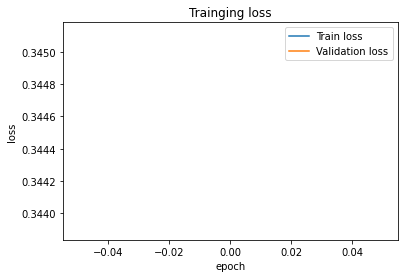

Train	 epoch: 2/10	 batch: 100/1343	 loss: 0.30020904541015625
Train	 epoch: 2/10	 batch: 200/1343	 loss: 0.2668597400188446
Train	 epoch: 2/10	 batch: 300/1343	 loss: 0.31694620847702026
Train	 epoch: 2/10	 batch: 400/1343	 loss: 0.2774829864501953
Train	 epoch: 2/10	 batch: 500/1343	 loss: 0.29433223605155945
Train	 epoch: 2/10	 batch: 600/1343	 loss: 0.29930007457733154
Train	 epoch: 2/10	 batch: 700/1343	 loss: 0.3086530864238739
Train	 epoch: 2/10	 batch: 800/1343	 loss: 0.26617252826690674
Train	 epoch: 2/10	 batch: 900/1343	 loss: 0.28513145446777344
Train	 epoch: 2/10	 batch: 1000/1343	 loss: 0.2512389123439789
Train	 epoch: 2/10	 batch: 1100/1343	 loss: 0.2968958020210266
Train	 epoch: 2/10	 batch: 1200/1343	 loss: 0.275458425283432
Train	 epoch: 2/10	 batch: 1300/1343	 loss: 0.2835950553417206
Train	 epoch: 2/10	 loss: 0.2742455757028206
Validation	 epoch: 2/10	 loss: 0.3392265737056732
Saving model


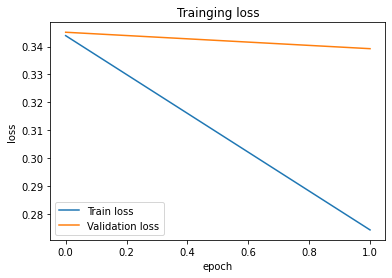

Train	 epoch: 3/10	 batch: 100/1343	 loss: 0.2747860550880432
Train	 epoch: 3/10	 batch: 200/1343	 loss: 0.25392961502075195
Train	 epoch: 3/10	 batch: 300/1343	 loss: 0.2532992959022522
Train	 epoch: 3/10	 batch: 400/1343	 loss: 0.27063971757888794
Train	 epoch: 3/10	 batch: 500/1343	 loss: 0.2688308358192444
Train	 epoch: 3/10	 batch: 600/1343	 loss: 0.2328200787305832
Train	 epoch: 3/10	 batch: 700/1343	 loss: 0.2654168903827667
Train	 epoch: 3/10	 batch: 800/1343	 loss: 0.278548926115036
Train	 epoch: 3/10	 batch: 900/1343	 loss: 0.2855411767959595
Train	 epoch: 3/10	 batch: 1000/1343	 loss: 0.2255917489528656
Train	 epoch: 3/10	 batch: 1100/1343	 loss: 0.22970402240753174
Train	 epoch: 3/10	 batch: 1200/1343	 loss: 0.2265060544013977
Train	 epoch: 3/10	 batch: 1300/1343	 loss: 0.21391478180885315
Train	 epoch: 3/10	 loss: 0.256292507917865
Validation	 epoch: 3/10	 loss: 0.4010368883609772


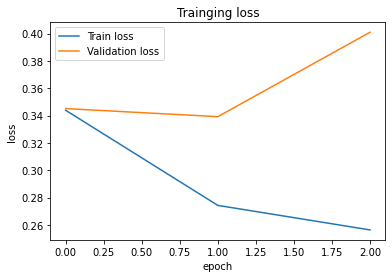

Train	 epoch: 4/10	 batch: 100/1343	 loss: 0.22158712148666382
Train	 epoch: 4/10	 batch: 200/1343	 loss: 0.23640304803848267
Train	 epoch: 4/10	 batch: 300/1343	 loss: 0.24555307626724243
Train	 epoch: 4/10	 batch: 400/1343	 loss: 0.23721195757389069
Train	 epoch: 4/10	 batch: 500/1343	 loss: 0.250934898853302
Train	 epoch: 4/10	 batch: 600/1343	 loss: 0.2423776537179947
Train	 epoch: 4/10	 batch: 700/1343	 loss: 0.26183730363845825
Train	 epoch: 4/10	 batch: 800/1343	 loss: 0.22307124733924866
Train	 epoch: 4/10	 batch: 900/1343	 loss: 0.22918465733528137
Train	 epoch: 4/10	 batch: 1000/1343	 loss: 0.22735269367694855
Train	 epoch: 4/10	 batch: 1100/1343	 loss: 0.2127256989479065
Train	 epoch: 4/10	 batch: 1200/1343	 loss: 0.21820800006389618
Train	 epoch: 4/10	 batch: 1300/1343	 loss: 0.22032764554023743
Train	 epoch: 4/10	 loss: 0.22954224439494572
Validation	 epoch: 4/10	 loss: 0.377652645111084
Saving model


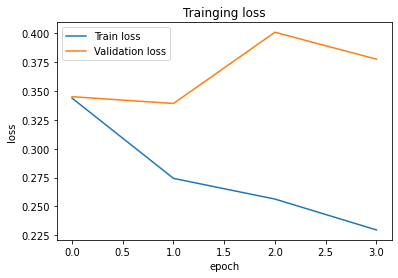

Train	 epoch: 5/10	 batch: 100/1343	 loss: 0.23052093386650085
Train	 epoch: 5/10	 batch: 200/1343	 loss: 0.2187589704990387
Train	 epoch: 5/10	 batch: 300/1343	 loss: 0.2037343531847
Train	 epoch: 5/10	 batch: 400/1343	 loss: 0.20046257972717285
Train	 epoch: 5/10	 batch: 500/1343	 loss: 0.23520366847515106
Train	 epoch: 5/10	 batch: 600/1343	 loss: 0.19401338696479797
Train	 epoch: 5/10	 batch: 700/1343	 loss: 0.2084101140499115
Train	 epoch: 5/10	 batch: 800/1343	 loss: 0.20242133736610413
Train	 epoch: 5/10	 batch: 900/1343	 loss: 0.21445706486701965
Train	 epoch: 5/10	 batch: 1000/1343	 loss: 0.18220943212509155
Train	 epoch: 5/10	 batch: 1100/1343	 loss: 0.20332711935043335
Train	 epoch: 5/10	 batch: 1200/1343	 loss: 0.22296181321144104
Train	 epoch: 5/10	 batch: 1300/1343	 loss: 0.2063242346048355
Train	 epoch: 5/10	 loss: 0.21003717003211278
Validation	 epoch: 5/10	 loss: 0.352630078792572


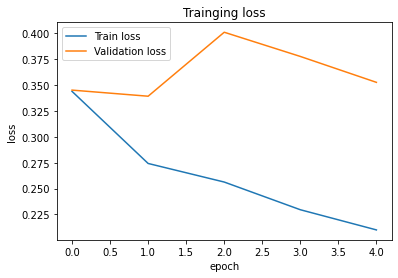

Train	 epoch: 6/10	 batch: 100/1343	 loss: 0.20611834526062012
Train	 epoch: 6/10	 batch: 200/1343	 loss: 0.1810866892337799
Train	 epoch: 6/10	 batch: 300/1343	 loss: 0.2145875245332718
Train	 epoch: 6/10	 batch: 400/1343	 loss: 0.22160804271697998
Train	 epoch: 6/10	 batch: 500/1343	 loss: 0.22317376732826233
Train	 epoch: 6/10	 batch: 600/1343	 loss: 0.1884792000055313
Train	 epoch: 6/10	 batch: 700/1343	 loss: 0.17857828736305237
Train	 epoch: 6/10	 batch: 800/1343	 loss: 0.23160728812217712
Train	 epoch: 6/10	 batch: 900/1343	 loss: 0.19293877482414246
Train	 epoch: 6/10	 batch: 1000/1343	 loss: 0.1906522512435913
Train	 epoch: 6/10	 batch: 1100/1343	 loss: 0.18993958830833435
Train	 epoch: 6/10	 batch: 1200/1343	 loss: 0.19856306910514832
Train	 epoch: 6/10	 batch: 1300/1343	 loss: 0.16620652377605438
Train	 epoch: 6/10	 loss: 0.19617216392230916
Validation	 epoch: 6/10	 loss: 0.35188212990760803
Saving model


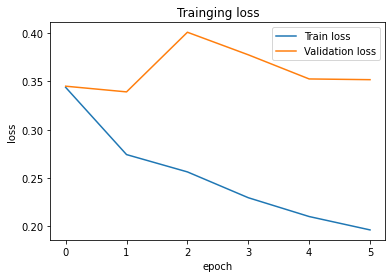

Train	 epoch: 7/10	 batch: 100/1343	 loss: 0.1625601202249527
Train	 epoch: 7/10	 batch: 200/1343	 loss: 0.17655694484710693
Train	 epoch: 7/10	 batch: 300/1343	 loss: 0.18455567955970764
Train	 epoch: 7/10	 batch: 400/1343	 loss: 0.20733214914798737
Train	 epoch: 7/10	 batch: 500/1343	 loss: 0.1793048083782196
Train	 epoch: 7/10	 batch: 600/1343	 loss: 0.19019268453121185
Train	 epoch: 7/10	 batch: 700/1343	 loss: 0.1804659515619278
Train	 epoch: 7/10	 batch: 800/1343	 loss: 0.2040402591228485
Train	 epoch: 7/10	 batch: 900/1343	 loss: 0.21523252129554749
Train	 epoch: 7/10	 batch: 1000/1343	 loss: 0.17056119441986084
Train	 epoch: 7/10	 batch: 1100/1343	 loss: 0.1992291510105133
Train	 epoch: 7/10	 batch: 1200/1343	 loss: 0.1861082762479782
Train	 epoch: 7/10	 batch: 1300/1343	 loss: 0.1777917742729187
Train	 epoch: 7/10	 loss: 0.18549069453776992
Validation	 epoch: 7/10	 loss: 0.3738538920879364


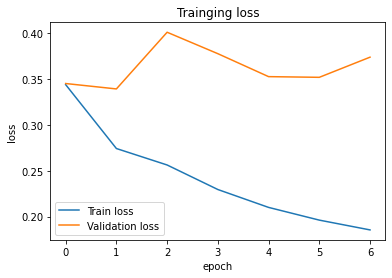

Train	 epoch: 8/10	 batch: 100/1343	 loss: 0.2275288850069046
Train	 epoch: 8/10	 batch: 200/1343	 loss: 0.16124555468559265
Train	 epoch: 8/10	 batch: 300/1343	 loss: 0.12894928455352783
Train	 epoch: 8/10	 batch: 400/1343	 loss: 0.18628248572349548
Train	 epoch: 8/10	 batch: 500/1343	 loss: 0.1856735646724701
Train	 epoch: 8/10	 batch: 600/1343	 loss: 0.18135181069374084
Train	 epoch: 8/10	 batch: 700/1343	 loss: 0.20162804424762726
Train	 epoch: 8/10	 batch: 800/1343	 loss: 0.18068912625312805
Train	 epoch: 8/10	 batch: 900/1343	 loss: 0.17101341485977173
Train	 epoch: 8/10	 batch: 1000/1343	 loss: 0.1554243266582489
Train	 epoch: 8/10	 batch: 1100/1343	 loss: 0.18640545010566711
Train	 epoch: 8/10	 batch: 1200/1343	 loss: 0.15220463275909424
Train	 epoch: 8/10	 batch: 1300/1343	 loss: 0.14530932903289795
Train	 epoch: 8/10	 loss: 0.17720421086317198
Validation	 epoch: 8/10	 loss: 0.37704265117645264
Saving model


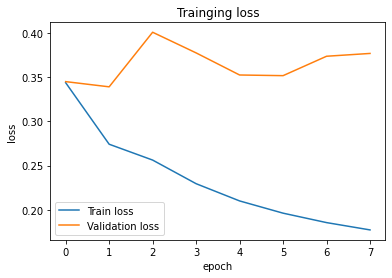

Train	 epoch: 9/10	 batch: 100/1343	 loss: 0.1499881148338318
Train	 epoch: 9/10	 batch: 200/1343	 loss: 0.1598474085330963
Train	 epoch: 9/10	 batch: 300/1343	 loss: 0.1769682765007019
Train	 epoch: 9/10	 batch: 400/1343	 loss: 0.1885533481836319
Train	 epoch: 9/10	 batch: 500/1343	 loss: 0.19415569305419922
Train	 epoch: 9/10	 batch: 600/1343	 loss: 0.18298476934432983
Train	 epoch: 9/10	 batch: 700/1343	 loss: 0.1854562610387802
Train	 epoch: 9/10	 batch: 800/1343	 loss: 0.188969224691391
Train	 epoch: 9/10	 batch: 900/1343	 loss: 0.1836060732603073
Train	 epoch: 9/10	 batch: 1000/1343	 loss: 0.1479068249464035
Train	 epoch: 9/10	 batch: 1100/1343	 loss: 0.1658417284488678
Train	 epoch: 9/10	 batch: 1200/1343	 loss: 0.17665506899356842
Train	 epoch: 9/10	 batch: 1300/1343	 loss: 0.1808326542377472
Train	 epoch: 9/10	 loss: 0.17025268972696694
Validation	 epoch: 9/10	 loss: 0.35422617197036743


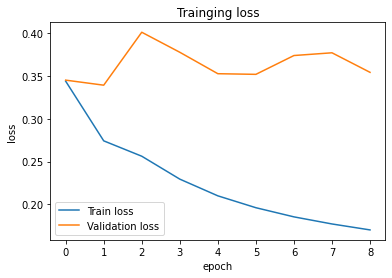

Train	 epoch: 10/10	 batch: 100/1343	 loss: 0.13282953202724457
Train	 epoch: 10/10	 batch: 200/1343	 loss: 0.14833098649978638
Train	 epoch: 10/10	 batch: 300/1343	 loss: 0.16420340538024902
Train	 epoch: 10/10	 batch: 400/1343	 loss: 0.14799712598323822
Train	 epoch: 10/10	 batch: 500/1343	 loss: 0.16811707615852356
Train	 epoch: 10/10	 batch: 600/1343	 loss: 0.1728827953338623
Train	 epoch: 10/10	 batch: 700/1343	 loss: 0.17605216801166534
Train	 epoch: 10/10	 batch: 800/1343	 loss: 0.17943529784679413
Train	 epoch: 10/10	 batch: 900/1343	 loss: 0.17003418505191803
Train	 epoch: 10/10	 batch: 1000/1343	 loss: 0.17424407601356506
Train	 epoch: 10/10	 batch: 1100/1343	 loss: 0.13915665447711945
Train	 epoch: 10/10	 batch: 1200/1343	 loss: 0.13315194845199585
Train	 epoch: 10/10	 batch: 1300/1343	 loss: 0.17685668170452118
Train	 epoch: 10/10	 loss: 0.16428866556395547
Validation	 epoch: 10/10	 loss: 0.3924432396888733
Saving model


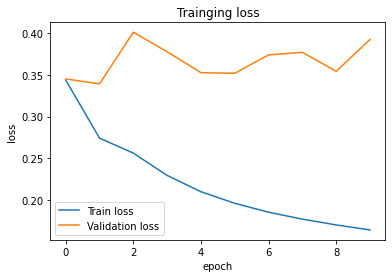

In [15]:
# Train the model
if (model_saved):
  print(f"Loading model from path: {savePath}")
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  train_loss_log = checkpoint['train_loss_log']
  val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 1 at epoch {start_epoch} succeed")
else:
  start_epoch = 0
  print("Phase 1: No model to load, start to train at epoch 0")

print("START TO TRAIN PHASE 1: Global Stage ...")
for epoch in range(start_epoch+1, ph1_epochs + 1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, _ = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)
    
    # Calculate train (global) loss
    with autocast():
      global_out, _, _, _, _ = model(window_batch)
      train_loss = ball_loss(global_out,xy_downscale) * global_weight

    #train_loss.backward()
    #optimizer.step()
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    
    train_loss_total += loss
    if((i+1)%100==0):
      print(f"Train\t epoch: {epoch}/{ph1_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

  # Log training losses
  print(f"Train\t epoch: {epoch}/{ph1_epochs}\t loss: {train_loss_total/batch_num}")
  train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():     
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs ,xy_downscale, _,_ = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device)      
      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale=torch.stack((ball_x,ball_y)).transpose(0,1)

      # Calculate local and val loss
      global_out, _, _, _, _ = model(window_batch)
      local_loss = ball_loss(global_out,xy_downscale) * global_weight
      val_loss = local_loss
      val_loss_total += val_loss.item()

    # Log validation losses
    val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph1_epochs}\t loss: {val_loss_total/batch_num}")
  
  # Save every 2 epochs
  if(epoch%2==0):
    print("Saving model")
    state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':train_loss_log,'val_loss_log':val_loss_log}
    savePath = savePath_base+f"TTNet_Phase1_{epoch}.pth"
    torch.save(state, savePath)
    model_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),train_loss_log,label='Train loss')
  plt.plot(range(epoch),val_loss_log,label='Validation loss')
  plt.legend()
  plt.xticks(range(epoch), range(1,11))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph1.png")
  plt.show()

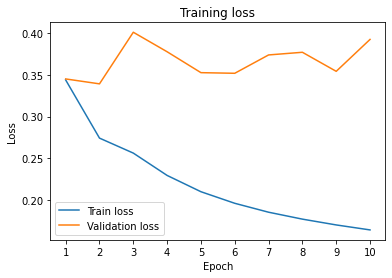

In [20]:
# Plot the losses
plt.clf()
plt.plot(range(epoch),train_loss_log,label='Train loss')
plt.plot(range(epoch),val_loss_log,label='Validation loss')
plt.legend()
plt.xticks(range(epoch), range(1,11))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.savefig(outputPath+"loss_ph1.png")
plt.show()

## Training Phase 2

In [13]:
# Training config
ph2_saved = False
ph2_epochs = 30
local_weight = 1
event_weight = 2
ph2_train_loss_log = []
ph2_val_loss_log = []

In [14]:
freeze_list = ["global_stage"]
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
model = freeze_model(model,freeze_list)                           
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

# TODO Rewrite this
def load_weights_local_stage(pretrained_dict):
  local_weights_dict = {}
  for layer_name, v in pretrained_dict.items():
    if 'global_stage' in layer_name:
      layer_name_parts = layer_name.split('.')
      layer_name_parts[1] = 'local_stage'
      local_name = '.'.join(layer_name_parts)
      local_weights_dict[local_name] = v

  return {**pretrained_dict, **local_weights_dict}



Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage
Freeze layer :global_stage


Phase 2: No model to load, start to train at epoch 0
START TO TRAIN PHASE 2: Local + Event Stage ...
+ Train	 epoch: 1/30	 batch: 500/2686	 loss: 0.20532235503196716
+ Train	 epoch: 1/30	 batch: 1000/2686	 loss: 0.19351299107074738
+ Train	 epoch: 1/30	 batch: 1500/2686	 loss: 0.18657326698303223
+ Train	 epoch: 1/30	 batch: 2000/2686	 loss: 0.18856322765350342
+ Train	 epoch: 1/30	 batch: 2500/2686	 loss: 0.2024729996919632
Train	 epoch: 1/30	 loss: 0.20498791840745723
Validation	 epoch: 1/30	 loss: 0.21464578807353973
Saving model


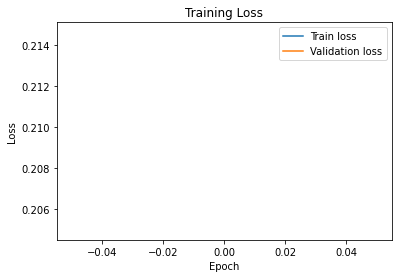

+ Train	 epoch: 2/30	 batch: 500/2686	 loss: 0.19096562266349792
+ Train	 epoch: 2/30	 batch: 1000/2686	 loss: 0.2018120288848877
+ Train	 epoch: 2/30	 batch: 1500/2686	 loss: 0.2049233317375183
+ Train	 epoch: 2/30	 batch: 2000/2686	 loss: 0.19373568892478943
+ Train	 epoch: 2/30	 batch: 2500/2686	 loss: 0.2223389446735382
Train	 epoch: 2/30	 loss: 0.19671069333580832
Validation	 epoch: 2/30	 loss: 0.19982750713825226
Saving model


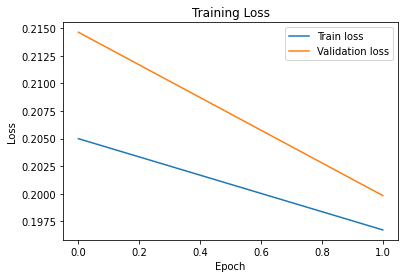

+ Train	 epoch: 3/30	 batch: 500/2686	 loss: 0.2257693111896515
+ Train	 epoch: 3/30	 batch: 1000/2686	 loss: 0.2100553810596466
+ Train	 epoch: 3/30	 batch: 1500/2686	 loss: 0.1916292905807495
+ Train	 epoch: 3/30	 batch: 2000/2686	 loss: 0.17527136206626892
+ Train	 epoch: 3/30	 batch: 2500/2686	 loss: 0.18630972504615784
Train	 epoch: 3/30	 loss: 0.1952240417308534
Validation	 epoch: 3/30	 loss: 0.17552170157432556
Saving model


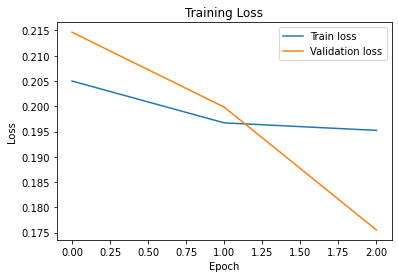

+ Train	 epoch: 4/30	 batch: 500/2686	 loss: 0.18595489859580994
+ Train	 epoch: 4/30	 batch: 1000/2686	 loss: 0.18141499161720276
+ Train	 epoch: 4/30	 batch: 1500/2686	 loss: 0.18546703457832336
+ Train	 epoch: 4/30	 batch: 2000/2686	 loss: 0.19569611549377441
+ Train	 epoch: 4/30	 batch: 2500/2686	 loss: 0.20842303335666656
Train	 epoch: 4/30	 loss: 0.19411809039000513
Validation	 epoch: 4/30	 loss: 0.20203247666358948
Saving model


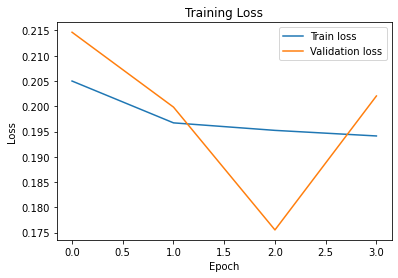

+ Train	 epoch: 5/30	 batch: 500/2686	 loss: 0.19666802883148193
+ Train	 epoch: 5/30	 batch: 1000/2686	 loss: 0.17945504188537598
+ Train	 epoch: 5/30	 batch: 1500/2686	 loss: 0.1877032369375229
+ Train	 epoch: 5/30	 batch: 2000/2686	 loss: 0.2185875028371811
+ Train	 epoch: 5/30	 batch: 2500/2686	 loss: 0.19216375052928925
Train	 epoch: 5/30	 loss: 0.19309389745998276
Validation	 epoch: 5/30	 loss: 0.19141219556331635
Saving model


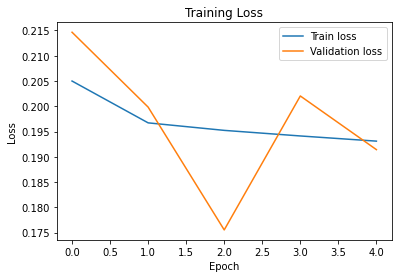

+ Train	 epoch: 6/30	 batch: 500/2686	 loss: 0.18762849271297455
+ Train	 epoch: 6/30	 batch: 1000/2686	 loss: 0.18745197355747223
+ Train	 epoch: 6/30	 batch: 1500/2686	 loss: 0.18465182185173035
+ Train	 epoch: 6/30	 batch: 2000/2686	 loss: 0.20539727807044983
+ Train	 epoch: 6/30	 batch: 2500/2686	 loss: 0.17788663506507874
Train	 epoch: 6/30	 loss: 0.1923535441784209
Validation	 epoch: 6/30	 loss: 0.20075300335884094
Saving model


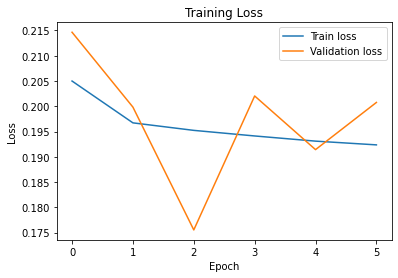

+ Train	 epoch: 7/30	 batch: 500/2686	 loss: 0.19611865282058716
+ Train	 epoch: 7/30	 batch: 1000/2686	 loss: 0.17060090601444244
+ Train	 epoch: 7/30	 batch: 1500/2686	 loss: 0.18736422061920166
+ Train	 epoch: 7/30	 batch: 2000/2686	 loss: 0.18153385818004608
+ Train	 epoch: 7/30	 batch: 2500/2686	 loss: 0.1898682713508606
Train	 epoch: 7/30	 loss: 0.19159439003631773
Validation	 epoch: 7/30	 loss: 0.1971229612827301
Saving model


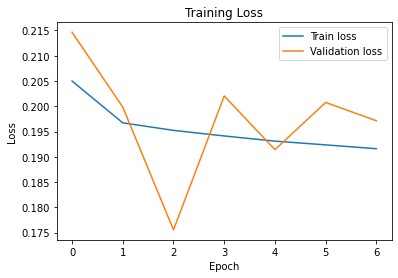

+ Train	 epoch: 8/30	 batch: 500/2686	 loss: 0.1944212168455124
+ Train	 epoch: 8/30	 batch: 1000/2686	 loss: 0.1817995011806488
+ Train	 epoch: 8/30	 batch: 1500/2686	 loss: 0.18384945392608643
+ Train	 epoch: 8/30	 batch: 2000/2686	 loss: 0.19309256970882416
+ Train	 epoch: 8/30	 batch: 2500/2686	 loss: 0.19388583302497864
Train	 epoch: 8/30	 loss: 0.19095380127163672
Validation	 epoch: 8/30	 loss: 0.16669915616512299
Saving model


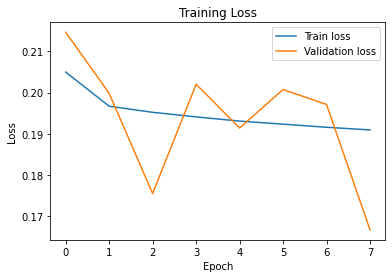

+ Train	 epoch: 9/30	 batch: 500/2686	 loss: 0.1949237585067749
+ Train	 epoch: 9/30	 batch: 1000/2686	 loss: 0.18706747889518738
+ Train	 epoch: 9/30	 batch: 1500/2686	 loss: 0.22403931617736816
+ Train	 epoch: 9/30	 batch: 2000/2686	 loss: 0.18894827365875244
+ Train	 epoch: 9/30	 batch: 2500/2686	 loss: 0.19719991087913513
Train	 epoch: 9/30	 loss: 0.19060331726708876
Validation	 epoch: 9/30	 loss: 0.18765193223953247
Saving model


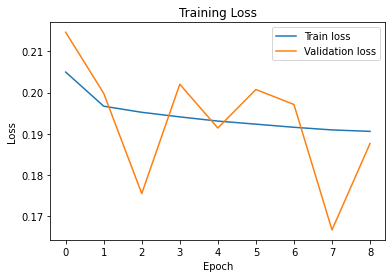

+ Train	 epoch: 10/30	 batch: 500/2686	 loss: 0.1661916971206665
+ Train	 epoch: 10/30	 batch: 1000/2686	 loss: 0.18330231308937073
+ Train	 epoch: 10/30	 batch: 1500/2686	 loss: 0.1859470009803772
+ Train	 epoch: 10/30	 batch: 2000/2686	 loss: 0.19020338356494904
+ Train	 epoch: 10/30	 batch: 2500/2686	 loss: 0.2018975019454956
Train	 epoch: 10/30	 loss: 0.19002192953430888
Validation	 epoch: 10/30	 loss: 0.19141435623168945
Saving model


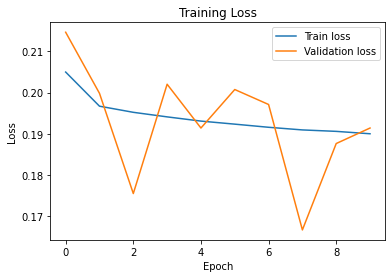

+ Train	 epoch: 11/30	 batch: 500/2686	 loss: 0.194864422082901
+ Train	 epoch: 11/30	 batch: 1000/2686	 loss: 0.16934941709041595
+ Train	 epoch: 11/30	 batch: 1500/2686	 loss: 0.21475672721862793
+ Train	 epoch: 11/30	 batch: 2000/2686	 loss: 0.19066482782363892
+ Train	 epoch: 11/30	 batch: 2500/2686	 loss: 0.16465918719768524
Train	 epoch: 11/30	 loss: 0.1895430809967303
Validation	 epoch: 11/30	 loss: 0.20551444590091705
Saving model


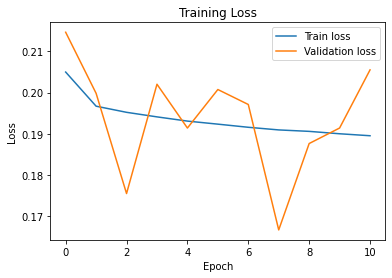

+ Train	 epoch: 12/30	 batch: 500/2686	 loss: 0.19730158150196075
+ Train	 epoch: 12/30	 batch: 1000/2686	 loss: 0.200444757938385
+ Train	 epoch: 12/30	 batch: 1500/2686	 loss: 0.1859646439552307
+ Train	 epoch: 12/30	 batch: 2000/2686	 loss: 0.1745748519897461
+ Train	 epoch: 12/30	 batch: 2500/2686	 loss: 0.16633851826190948
Train	 epoch: 12/30	 loss: 0.18921440137981568
Validation	 epoch: 12/30	 loss: 0.17333027720451355
Saving model


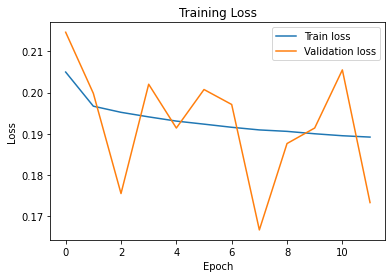

+ Train	 epoch: 13/30	 batch: 500/2686	 loss: 0.19563141465187073
+ Train	 epoch: 13/30	 batch: 1000/2686	 loss: 0.2093510925769806
+ Train	 epoch: 13/30	 batch: 1500/2686	 loss: 0.18568268418312073
+ Train	 epoch: 13/30	 batch: 2000/2686	 loss: 0.19144850969314575
+ Train	 epoch: 13/30	 batch: 2500/2686	 loss: 0.19657066464424133
Train	 epoch: 13/30	 loss: 0.188906239729849
Validation	 epoch: 13/30	 loss: 0.19129778444766998
Saving model


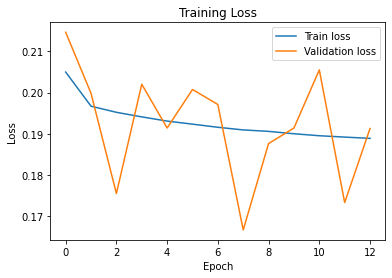

+ Train	 epoch: 14/30	 batch: 500/2686	 loss: 0.16964185237884521
+ Train	 epoch: 14/30	 batch: 1000/2686	 loss: 0.18533189594745636
+ Train	 epoch: 14/30	 batch: 1500/2686	 loss: 0.1628173440694809
+ Train	 epoch: 14/30	 batch: 2000/2686	 loss: 0.18420177698135376
+ Train	 epoch: 14/30	 batch: 2500/2686	 loss: 0.178534597158432
Train	 epoch: 14/30	 loss: 0.18852804902433373
Validation	 epoch: 14/30	 loss: 0.1905907392501831
Saving model


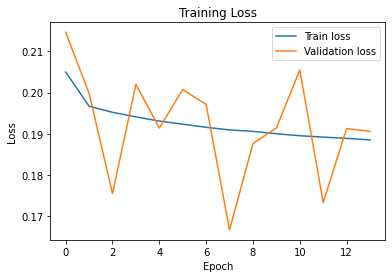

+ Train	 epoch: 15/30	 batch: 500/2686	 loss: 0.2056579291820526
+ Train	 epoch: 15/30	 batch: 1000/2686	 loss: 0.18677769601345062
+ Train	 epoch: 15/30	 batch: 1500/2686	 loss: 0.1909237802028656
+ Train	 epoch: 15/30	 batch: 2000/2686	 loss: 0.16932499408721924
+ Train	 epoch: 15/30	 batch: 2500/2686	 loss: 0.19212310016155243
Train	 epoch: 15/30	 loss: 0.18830847162656258
Validation	 epoch: 15/30	 loss: 0.16095483303070068
Saving model


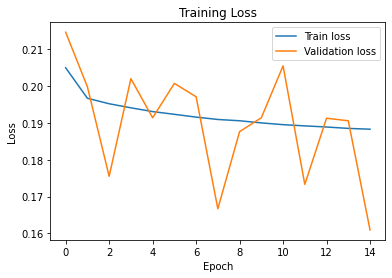

+ Train	 epoch: 16/30	 batch: 500/2686	 loss: 0.16326145827770233
+ Train	 epoch: 16/30	 batch: 1000/2686	 loss: 0.18586435914039612
+ Train	 epoch: 16/30	 batch: 1500/2686	 loss: 0.20979617536067963
+ Train	 epoch: 16/30	 batch: 2000/2686	 loss: 0.17335067689418793
+ Train	 epoch: 16/30	 batch: 2500/2686	 loss: 0.1654481291770935
Train	 epoch: 16/30	 loss: 0.18815360536170556
Validation	 epoch: 16/30	 loss: 0.17440930008888245
Saving model


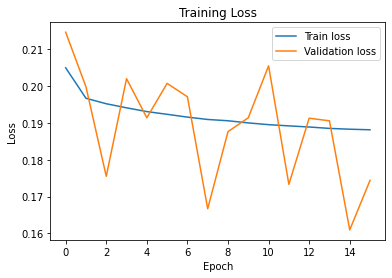

+ Train	 epoch: 17/30	 batch: 500/2686	 loss: 0.17531926929950714
+ Train	 epoch: 17/30	 batch: 1000/2686	 loss: 0.17191636562347412
+ Train	 epoch: 17/30	 batch: 1500/2686	 loss: 0.19261284172534943
+ Train	 epoch: 17/30	 batch: 2000/2686	 loss: 0.16939574480056763
+ Train	 epoch: 17/30	 batch: 2500/2686	 loss: 0.17817816138267517
Train	 epoch: 17/30	 loss: 0.18762745932354824
Validation	 epoch: 17/30	 loss: 0.1977628916501999
Saving model


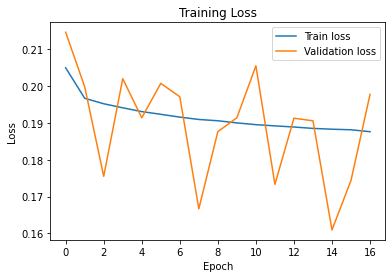

+ Train	 epoch: 18/30	 batch: 500/2686	 loss: 0.1986997276544571
+ Train	 epoch: 18/30	 batch: 1000/2686	 loss: 0.185214102268219
+ Train	 epoch: 18/30	 batch: 1500/2686	 loss: 0.1892072856426239
+ Train	 epoch: 18/30	 batch: 2000/2686	 loss: 0.17695042490959167
+ Train	 epoch: 18/30	 batch: 2500/2686	 loss: 0.18987461924552917
Train	 epoch: 18/30	 loss: 0.18742347155834257
Validation	 epoch: 18/30	 loss: 0.16312187910079956
Saving model


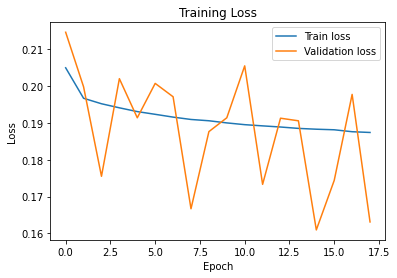

+ Train	 epoch: 19/30	 batch: 500/2686	 loss: 0.1837240308523178
+ Train	 epoch: 19/30	 batch: 1000/2686	 loss: 0.16222737729549408
+ Train	 epoch: 19/30	 batch: 1500/2686	 loss: 0.19023697078227997
+ Train	 epoch: 19/30	 batch: 2000/2686	 loss: 0.17286719381809235
+ Train	 epoch: 19/30	 batch: 2500/2686	 loss: 0.19693316519260406
Train	 epoch: 19/30	 loss: 0.18679276138144646
Validation	 epoch: 19/30	 loss: 0.17010658979415894
Saving model


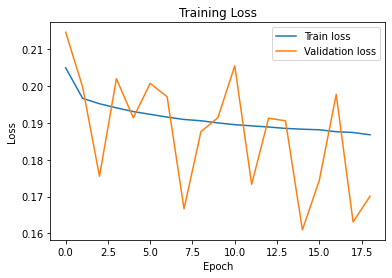

+ Train	 epoch: 20/30	 batch: 500/2686	 loss: 0.1783745288848877
+ Train	 epoch: 20/30	 batch: 1000/2686	 loss: 0.19049300253391266
+ Train	 epoch: 20/30	 batch: 1500/2686	 loss: 0.196477010846138
+ Train	 epoch: 20/30	 batch: 2000/2686	 loss: 0.17568939924240112
+ Train	 epoch: 20/30	 batch: 2500/2686	 loss: 0.16128557920455933
Train	 epoch: 20/30	 loss: 0.1864083255970558
Validation	 epoch: 20/30	 loss: 0.17731668055057526
Saving model


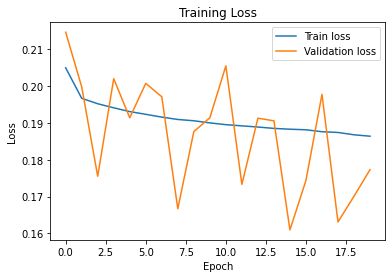

+ Train	 epoch: 21/30	 batch: 500/2686	 loss: 0.19167295098304749
+ Train	 epoch: 21/30	 batch: 1000/2686	 loss: 0.18438765406608582
+ Train	 epoch: 21/30	 batch: 1500/2686	 loss: 0.19045498967170715
+ Train	 epoch: 21/30	 batch: 2000/2686	 loss: 0.17745834589004517
+ Train	 epoch: 21/30	 batch: 2500/2686	 loss: 0.1642671823501587
Train	 epoch: 21/30	 loss: 0.18542825512183042
Validation	 epoch: 21/30	 loss: 0.1734570860862732
Saving model


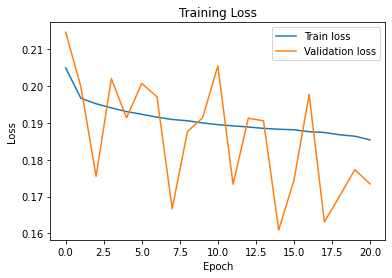

+ Train	 epoch: 22/30	 batch: 500/2686	 loss: 0.16461877524852753
+ Train	 epoch: 22/30	 batch: 1000/2686	 loss: 0.17940835654735565
+ Train	 epoch: 22/30	 batch: 1500/2686	 loss: 0.19667871296405792
+ Train	 epoch: 22/30	 batch: 2000/2686	 loss: 0.1755276769399643
+ Train	 epoch: 22/30	 batch: 2500/2686	 loss: 0.16925305128097534
Train	 epoch: 22/30	 loss: 0.18485971063109183
Validation	 epoch: 22/30	 loss: 0.22153350710868835
Saving model


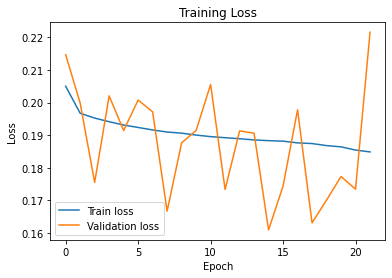

+ Train	 epoch: 23/30	 batch: 500/2686	 loss: 0.18181349337100983
+ Train	 epoch: 23/30	 batch: 1000/2686	 loss: 0.18823784589767456
+ Train	 epoch: 23/30	 batch: 1500/2686	 loss: 0.1784217804670334
+ Train	 epoch: 23/30	 batch: 2000/2686	 loss: 0.1926994025707245
+ Train	 epoch: 23/30	 batch: 2500/2686	 loss: 0.19793660938739777
Train	 epoch: 23/30	 loss: 0.1841994777643583
Validation	 epoch: 23/30	 loss: 0.17550687491893768
Saving model


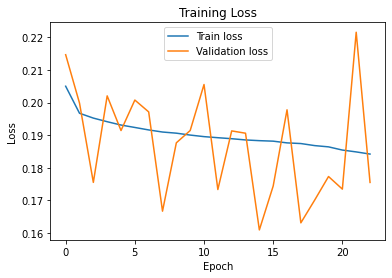

+ Train	 epoch: 24/30	 batch: 500/2686	 loss: 0.19574110209941864
+ Train	 epoch: 24/30	 batch: 1000/2686	 loss: 0.23091915249824524
+ Train	 epoch: 24/30	 batch: 1500/2686	 loss: 0.1877565234899521
+ Train	 epoch: 24/30	 batch: 2000/2686	 loss: 0.18352724611759186
+ Train	 epoch: 24/30	 batch: 2500/2686	 loss: 0.19548043608665466
Train	 epoch: 24/30	 loss: 0.1838241717538901
Validation	 epoch: 24/30	 loss: 0.19851845502853394
Saving model


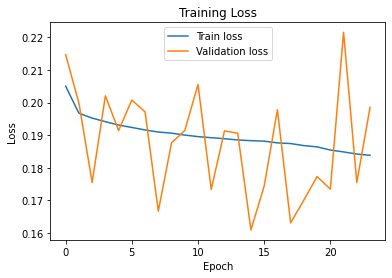

+ Train	 epoch: 25/30	 batch: 500/2686	 loss: 0.16973218321800232
+ Train	 epoch: 25/30	 batch: 1000/2686	 loss: 0.17922984063625336
+ Train	 epoch: 25/30	 batch: 1500/2686	 loss: 0.2090461403131485
+ Train	 epoch: 25/30	 batch: 2000/2686	 loss: 0.1772421896457672
+ Train	 epoch: 25/30	 batch: 2500/2686	 loss: 0.1688372790813446
Train	 epoch: 25/30	 loss: 0.1832736571023292
Validation	 epoch: 25/30	 loss: 0.18355166912078857
Saving model


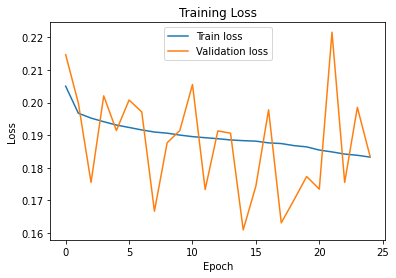

+ Train	 epoch: 26/30	 batch: 500/2686	 loss: 0.17501793801784515
+ Train	 epoch: 26/30	 batch: 1000/2686	 loss: 0.18624065816402435
+ Train	 epoch: 26/30	 batch: 1500/2686	 loss: 0.16942957043647766
+ Train	 epoch: 26/30	 batch: 2000/2686	 loss: 0.17459726333618164
+ Train	 epoch: 26/30	 batch: 2500/2686	 loss: 0.18674197793006897
Train	 epoch: 26/30	 loss: 0.18299951672287726
Validation	 epoch: 26/30	 loss: 0.16175077855587006
Saving model


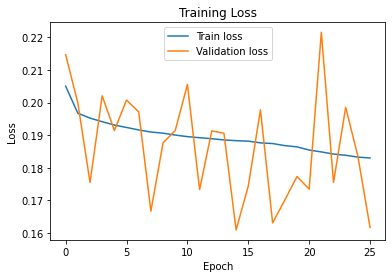

+ Train	 epoch: 27/30	 batch: 500/2686	 loss: 0.17485058307647705
+ Train	 epoch: 27/30	 batch: 1000/2686	 loss: 0.21805237233638763
+ Train	 epoch: 27/30	 batch: 1500/2686	 loss: 0.19328077137470245
+ Train	 epoch: 27/30	 batch: 2000/2686	 loss: 0.17255181074142456
+ Train	 epoch: 27/30	 batch: 2500/2686	 loss: 0.18228188157081604
Train	 epoch: 27/30	 loss: 0.18259767893970855
Validation	 epoch: 27/30	 loss: 0.18155455589294434
Saving model


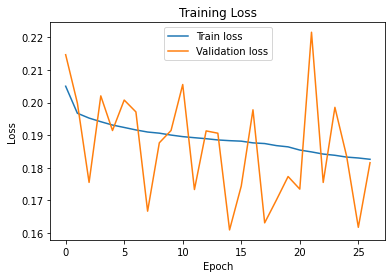

+ Train	 epoch: 28/30	 batch: 500/2686	 loss: 0.18215548992156982
+ Train	 epoch: 28/30	 batch: 1000/2686	 loss: 0.19062554836273193
+ Train	 epoch: 28/30	 batch: 1500/2686	 loss: 0.16912740468978882
+ Train	 epoch: 28/30	 batch: 2000/2686	 loss: 0.17182764410972595
+ Train	 epoch: 28/30	 batch: 2500/2686	 loss: 0.19677990674972534
Train	 epoch: 28/30	 loss: 0.18227638977726093
Validation	 epoch: 28/30	 loss: 0.2016388475894928
Saving model


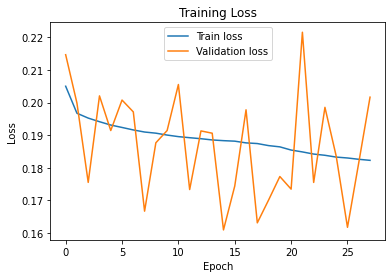

+ Train	 epoch: 29/30	 batch: 500/2686	 loss: 0.1816950887441635
+ Train	 epoch: 29/30	 batch: 1000/2686	 loss: 0.18087820708751678
+ Train	 epoch: 29/30	 batch: 1500/2686	 loss: 0.17336471378803253
+ Train	 epoch: 29/30	 batch: 2000/2686	 loss: 0.16799266636371613
+ Train	 epoch: 29/30	 batch: 2500/2686	 loss: 0.1663801372051239
Train	 epoch: 29/30	 loss: 0.18200442013528395
Validation	 epoch: 29/30	 loss: 0.20221488177776337
Saving model


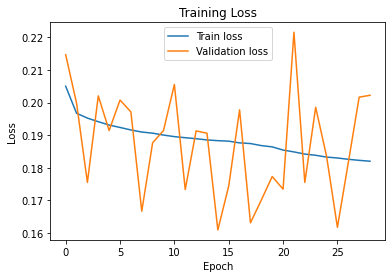

+ Train	 epoch: 30/30	 batch: 500/2686	 loss: 0.17826659977436066
+ Train	 epoch: 30/30	 batch: 1000/2686	 loss: 0.17803342640399933
+ Train	 epoch: 30/30	 batch: 1500/2686	 loss: 0.16756577789783478
+ Train	 epoch: 30/30	 batch: 2000/2686	 loss: 0.18879565596580505
+ Train	 epoch: 30/30	 batch: 2500/2686	 loss: 0.17170460522174835
Train	 epoch: 30/30	 loss: 0.18156146542158752
Validation	 epoch: 30/30	 loss: 0.17575934529304504
Saving model


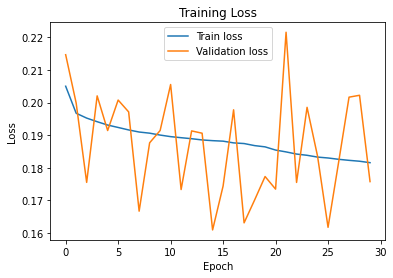

In [15]:
if ph2_saved:
  savePath = savePath_base+"TTNet_Phase2_1.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph2_train_loss_log = checkpoint['train_loss_log']
  ph2_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 2 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"TTNet_Phase1_10.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  pretrained_dict = load_weights_local_stage(pretrained_dict)
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  start_epoch = 0
  print("Phase 2: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 2: Local + Event Stage ...')

for epoch in range(start_epoch+1, ph2_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()
    
    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

    # Model forward step
    with autocast():
      _, local_out, _, crop_params, event_out = model(window_batch)

    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (local+event) loss
    with autocast():
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = local_loss_train + event_loss_train
    
    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph2_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")

    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainig losses
  print(f"Train\t epoch: {epoch}/{ph2_epochs}\t loss: {train_loss_total/batch_num}")
  ph2_train_loss_log.append(train_loss_total/batch_num)

  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      with autocast():
        _, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (local+event) loss
      with autocast():
        local_loss_val = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_val = event_loss(event_out,event_probs) * event_weight
        val_loss = local_loss_val + event_loss_val

      loss = train_loss.detach().cpu().numpy()
      val_loss_total += loss
      #val_loss_total += val_loss.item()

    ph2_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph2_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"TTNet_Phase2_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph2_train_loss_log,'val_loss_log':ph2_val_loss_log}
  torch.save(state, savePath) 
  ph2_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph2_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph2_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph2.png")
  plt.show()

## Training Phase 3

In [14]:
# Training config
ph3_saved = False
ph3_epochs = 20
global_weight = 1
local_weight = 1
event_weight = 1
ph3_train_loss_log = []
ph3_val_loss_log = []

In [15]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
train_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(train_params,lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

Phase 3: No model to load, start to train at epoch 0
START TO TRAIN PHASE 3: All Stages ...
+ Train	 epoch: 1/20	 batch: 500/5373	 loss: 0.12870855629444122
+ Train	 epoch: 1/20	 batch: 1000/5373	 loss: 0.15121468901634216
+ Train	 epoch: 1/20	 batch: 1500/5373	 loss: 0.1397198587656021
+ Train	 epoch: 1/20	 batch: 2000/5373	 loss: 0.12285864353179932
+ Train	 epoch: 1/20	 batch: 2500/5373	 loss: 0.1573992669582367
+ Train	 epoch: 1/20	 batch: 3000/5373	 loss: 0.13703641295433044
+ Train	 epoch: 1/20	 batch: 3500/5373	 loss: 0.134092777967453
+ Train	 epoch: 1/20	 batch: 4000/5373	 loss: 0.14080262184143066
+ Train	 epoch: 1/20	 batch: 4500/5373	 loss: 0.17744630575180054
+ Train	 epoch: 1/20	 batch: 5000/5373	 loss: 0.1423064023256302
Train	 epoch: 1/20	 loss: 0.14486721217931814
Validation	 epoch: 1/20	 loss: 0.14589270949363708
Saving model


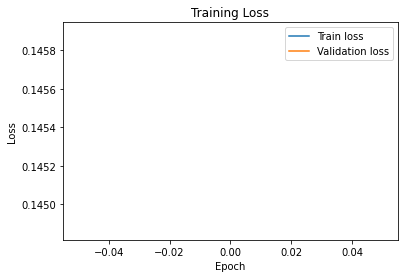

+ Train	 epoch: 2/20	 batch: 500/5373	 loss: 0.15817949175834656
+ Train	 epoch: 2/20	 batch: 1000/5373	 loss: 0.1327589452266693
+ Train	 epoch: 2/20	 batch: 1500/5373	 loss: 0.1347936987876892
+ Train	 epoch: 2/20	 batch: 2000/5373	 loss: 0.1376224160194397
+ Train	 epoch: 2/20	 batch: 2500/5373	 loss: 0.11164990067481995
+ Train	 epoch: 2/20	 batch: 3000/5373	 loss: 0.1378973424434662
+ Train	 epoch: 2/20	 batch: 3500/5373	 loss: 0.12732115387916565
+ Train	 epoch: 2/20	 batch: 4000/5373	 loss: 0.14189374446868896
+ Train	 epoch: 2/20	 batch: 4500/5373	 loss: 0.14906254410743713
+ Train	 epoch: 2/20	 batch: 5000/5373	 loss: 0.16400116682052612
Train	 epoch: 2/20	 loss: 0.14312007868925597
Validation	 epoch: 2/20	 loss: 0.15182927250862122
Saving model


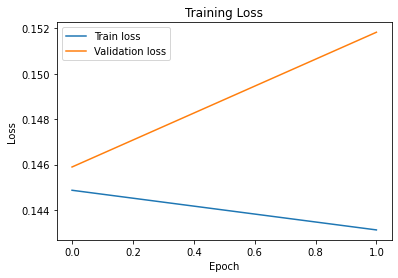

+ Train	 epoch: 3/20	 batch: 500/5373	 loss: 0.14138740301132202
+ Train	 epoch: 3/20	 batch: 1000/5373	 loss: 0.1395128220319748
+ Train	 epoch: 3/20	 batch: 1500/5373	 loss: 0.1283653825521469
+ Train	 epoch: 3/20	 batch: 2000/5373	 loss: 0.13433505594730377
+ Train	 epoch: 3/20	 batch: 2500/5373	 loss: 0.134550541639328
+ Train	 epoch: 3/20	 batch: 3000/5373	 loss: 0.12234082072973251
+ Train	 epoch: 3/20	 batch: 3500/5373	 loss: 0.1691151261329651
+ Train	 epoch: 3/20	 batch: 4000/5373	 loss: 0.10139158368110657
+ Train	 epoch: 3/20	 batch: 4500/5373	 loss: 0.14745798707008362
+ Train	 epoch: 3/20	 batch: 5000/5373	 loss: 0.13793906569480896
Train	 epoch: 3/20	 loss: 0.14157244588062792
Validation	 epoch: 3/20	 loss: 0.12340037524700165
Saving model


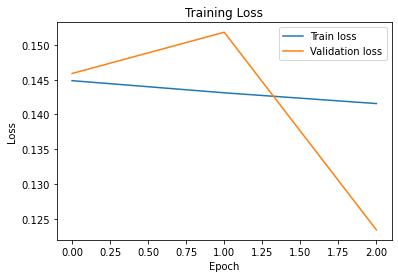

+ Train	 epoch: 4/20	 batch: 500/5373	 loss: 0.15298742055892944
+ Train	 epoch: 4/20	 batch: 1000/5373	 loss: 0.11437475681304932
+ Train	 epoch: 4/20	 batch: 1500/5373	 loss: 0.13850125670433044
+ Train	 epoch: 4/20	 batch: 2000/5373	 loss: 0.14791834354400635
+ Train	 epoch: 4/20	 batch: 2500/5373	 loss: 0.16495569050312042
+ Train	 epoch: 4/20	 batch: 3000/5373	 loss: 0.1246211975812912
+ Train	 epoch: 4/20	 batch: 3500/5373	 loss: 0.1651151478290558
+ Train	 epoch: 4/20	 batch: 4000/5373	 loss: 0.15711694955825806
+ Train	 epoch: 4/20	 batch: 4500/5373	 loss: 0.13738960027694702
+ Train	 epoch: 4/20	 batch: 5000/5373	 loss: 0.14245754480361938
Train	 epoch: 4/20	 loss: 0.1401255990614466
Validation	 epoch: 4/20	 loss: 0.13617604970932007
Saving model


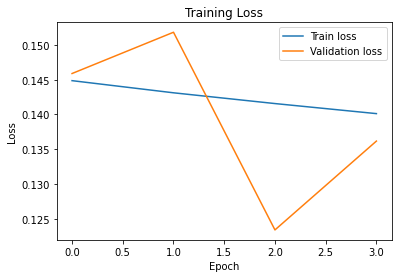

+ Train	 epoch: 5/20	 batch: 500/5373	 loss: 0.14014488458633423
+ Train	 epoch: 5/20	 batch: 1000/5373	 loss: 0.14586728811264038
+ Train	 epoch: 5/20	 batch: 1500/5373	 loss: 0.13577967882156372
+ Train	 epoch: 5/20	 batch: 2000/5373	 loss: 0.10918814688920975
+ Train	 epoch: 5/20	 batch: 2500/5373	 loss: 0.14793121814727783
+ Train	 epoch: 5/20	 batch: 3000/5373	 loss: 0.15786299109458923
+ Train	 epoch: 5/20	 batch: 3500/5373	 loss: 0.13077907264232635
+ Train	 epoch: 5/20	 batch: 4000/5373	 loss: 0.16505929827690125
+ Train	 epoch: 5/20	 batch: 4500/5373	 loss: 0.13468299806118011
+ Train	 epoch: 5/20	 batch: 5000/5373	 loss: 0.13538095355033875
Train	 epoch: 5/20	 loss: 0.13894805507538552
Validation	 epoch: 5/20	 loss: 0.15680494904518127
Saving model


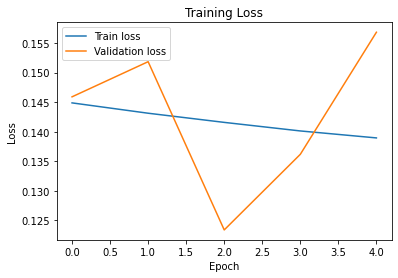

+ Train	 epoch: 6/20	 batch: 500/5373	 loss: 0.11947616934776306
+ Train	 epoch: 6/20	 batch: 1000/5373	 loss: 0.139863982796669
+ Train	 epoch: 6/20	 batch: 1500/5373	 loss: 0.17220813035964966
+ Train	 epoch: 6/20	 batch: 2000/5373	 loss: 0.14522412419319153
+ Train	 epoch: 6/20	 batch: 2500/5373	 loss: 0.12712611258029938
+ Train	 epoch: 6/20	 batch: 3000/5373	 loss: 0.13280674815177917
+ Train	 epoch: 6/20	 batch: 3500/5373	 loss: 0.15746532380580902
+ Train	 epoch: 6/20	 batch: 4000/5373	 loss: 0.1318317949771881
+ Train	 epoch: 6/20	 batch: 4500/5373	 loss: 0.1308051496744156
+ Train	 epoch: 6/20	 batch: 5000/5373	 loss: 0.1351315975189209
Train	 epoch: 6/20	 loss: 0.1378486621497442
Validation	 epoch: 6/20	 loss: 0.13074173033237457
Saving model


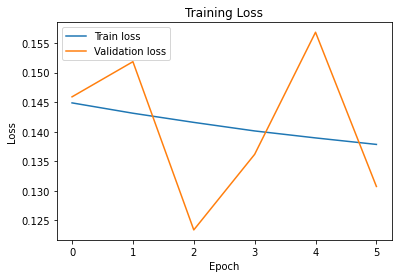

+ Train	 epoch: 7/20	 batch: 500/5373	 loss: 0.11074497550725937
+ Train	 epoch: 7/20	 batch: 1000/5373	 loss: 0.1511843204498291
+ Train	 epoch: 7/20	 batch: 1500/5373	 loss: 0.13805058598518372
+ Train	 epoch: 7/20	 batch: 2000/5373	 loss: 0.1113780289888382
+ Train	 epoch: 7/20	 batch: 2500/5373	 loss: 0.12338526546955109
+ Train	 epoch: 7/20	 batch: 3000/5373	 loss: 0.141841322183609
+ Train	 epoch: 7/20	 batch: 3500/5373	 loss: 0.1436668336391449
+ Train	 epoch: 7/20	 batch: 4000/5373	 loss: 0.16429337859153748
+ Train	 epoch: 7/20	 batch: 4500/5373	 loss: 0.1314961463212967
+ Train	 epoch: 7/20	 batch: 5000/5373	 loss: 0.17131346464157104
Train	 epoch: 7/20	 loss: 0.13658150994348367
Validation	 epoch: 7/20	 loss: 0.12841032445430756
Saving model


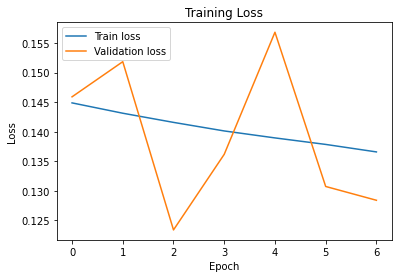

+ Train	 epoch: 8/20	 batch: 500/5373	 loss: 0.14959660172462463
+ Train	 epoch: 8/20	 batch: 1000/5373	 loss: 0.10268249362707138
+ Train	 epoch: 8/20	 batch: 1500/5373	 loss: 0.13574905693531036
+ Train	 epoch: 8/20	 batch: 2000/5373	 loss: 0.13226431608200073
+ Train	 epoch: 8/20	 batch: 2500/5373	 loss: 0.14818719029426575
+ Train	 epoch: 8/20	 batch: 3000/5373	 loss: 0.14229385554790497
+ Train	 epoch: 8/20	 batch: 3500/5373	 loss: 0.13860729336738586
+ Train	 epoch: 8/20	 batch: 4000/5373	 loss: 0.12835296988487244
+ Train	 epoch: 8/20	 batch: 4500/5373	 loss: 0.09750895202159882
+ Train	 epoch: 8/20	 batch: 5000/5373	 loss: 0.1298644244670868
Train	 epoch: 8/20	 loss: 0.13542346403116445
Validation	 epoch: 8/20	 loss: 0.11867394298315048
Saving model


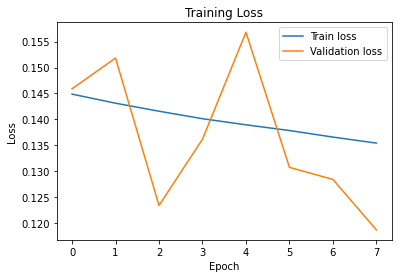

+ Train	 epoch: 9/20	 batch: 500/5373	 loss: 0.13880819082260132
+ Train	 epoch: 9/20	 batch: 1000/5373	 loss: 0.13944274187088013
+ Train	 epoch: 9/20	 batch: 1500/5373	 loss: 0.1364816129207611
+ Train	 epoch: 9/20	 batch: 2000/5373	 loss: 0.1284211277961731
+ Train	 epoch: 9/20	 batch: 2500/5373	 loss: 0.14820095896720886
+ Train	 epoch: 9/20	 batch: 3000/5373	 loss: 0.11696264147758484
+ Train	 epoch: 9/20	 batch: 3500/5373	 loss: 0.12584348022937775
+ Train	 epoch: 9/20	 batch: 4000/5373	 loss: 0.130476713180542
+ Train	 epoch: 9/20	 batch: 4500/5373	 loss: 0.11255206167697906
+ Train	 epoch: 9/20	 batch: 5000/5373	 loss: 0.1528872549533844
Train	 epoch: 9/20	 loss: 0.134731399539838
Validation	 epoch: 9/20	 loss: 0.11513738334178925
Saving model


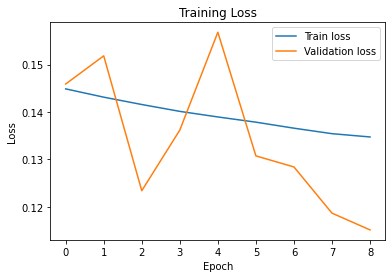

+ Train	 epoch: 10/20	 batch: 500/5373	 loss: 0.1255708634853363
+ Train	 epoch: 10/20	 batch: 1000/5373	 loss: 0.10652242600917816
+ Train	 epoch: 10/20	 batch: 1500/5373	 loss: 0.096066914498806
+ Train	 epoch: 10/20	 batch: 2000/5373	 loss: 0.13113638758659363
+ Train	 epoch: 10/20	 batch: 2500/5373	 loss: 0.13485701382160187
+ Train	 epoch: 10/20	 batch: 3000/5373	 loss: 0.1306256800889969
+ Train	 epoch: 10/20	 batch: 3500/5373	 loss: 0.1333540380001068
+ Train	 epoch: 10/20	 batch: 4000/5373	 loss: 0.11884906142950058
+ Train	 epoch: 10/20	 batch: 4500/5373	 loss: 0.1666516363620758
+ Train	 epoch: 10/20	 batch: 5000/5373	 loss: 0.1468522548675537
Train	 epoch: 10/20	 loss: 0.13368434099407364
Validation	 epoch: 10/20	 loss: 0.12540343403816223
Saving model


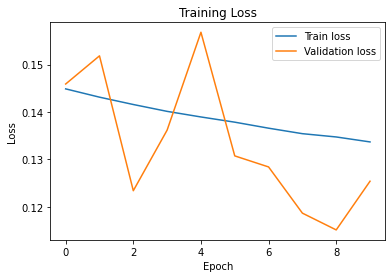

+ Train	 epoch: 11/20	 batch: 500/5373	 loss: 0.1267613172531128
+ Train	 epoch: 11/20	 batch: 1000/5373	 loss: 0.13530509173870087
+ Train	 epoch: 11/20	 batch: 1500/5373	 loss: 0.13171976804733276
+ Train	 epoch: 11/20	 batch: 2000/5373	 loss: 0.1360251009464264
+ Train	 epoch: 11/20	 batch: 2500/5373	 loss: 0.10336913913488388
+ Train	 epoch: 11/20	 batch: 3000/5373	 loss: 0.1207096204161644
+ Train	 epoch: 11/20	 batch: 3500/5373	 loss: 0.13847684860229492
+ Train	 epoch: 11/20	 batch: 4000/5373	 loss: 0.15128862857818604
+ Train	 epoch: 11/20	 batch: 4500/5373	 loss: 0.1381406933069229
+ Train	 epoch: 11/20	 batch: 5000/5373	 loss: 0.12374678254127502
Train	 epoch: 11/20	 loss: 0.1330314479406355
Validation	 epoch: 11/20	 loss: 0.1263611763715744
Saving model


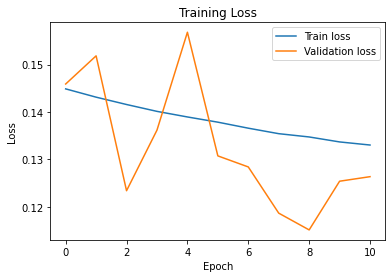

+ Train	 epoch: 12/20	 batch: 500/5373	 loss: 0.13893231749534607
+ Train	 epoch: 12/20	 batch: 1000/5373	 loss: 0.10962893813848495
+ Train	 epoch: 12/20	 batch: 1500/5373	 loss: 0.15022334456443787
+ Train	 epoch: 12/20	 batch: 2000/5373	 loss: 0.12162759900093079
+ Train	 epoch: 12/20	 batch: 2500/5373	 loss: 0.14504462480545044
+ Train	 epoch: 12/20	 batch: 3000/5373	 loss: 0.11745668202638626
+ Train	 epoch: 12/20	 batch: 3500/5373	 loss: 0.12198778241872787
+ Train	 epoch: 12/20	 batch: 4000/5373	 loss: 0.13027231395244598
+ Train	 epoch: 12/20	 batch: 4500/5373	 loss: 0.14944520592689514
+ Train	 epoch: 12/20	 batch: 5000/5373	 loss: 0.09938661754131317
Train	 epoch: 12/20	 loss: 0.13207072048974441
Validation	 epoch: 12/20	 loss: 0.11408677697181702
Saving model


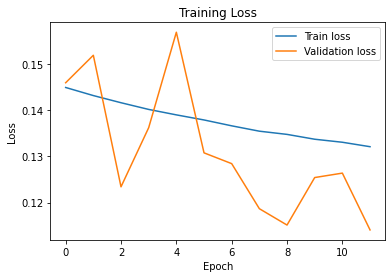

+ Train	 epoch: 13/20	 batch: 500/5373	 loss: 0.13086894154548645
+ Train	 epoch: 13/20	 batch: 1000/5373	 loss: 0.11867469549179077
+ Train	 epoch: 13/20	 batch: 1500/5373	 loss: 0.1295349895954132
+ Train	 epoch: 13/20	 batch: 2000/5373	 loss: 0.14072227478027344
+ Train	 epoch: 13/20	 batch: 2500/5373	 loss: 0.12997809052467346
+ Train	 epoch: 13/20	 batch: 3000/5373	 loss: 0.12963001430034637
+ Train	 epoch: 13/20	 batch: 3500/5373	 loss: 0.1353348195552826
+ Train	 epoch: 13/20	 batch: 4000/5373	 loss: 0.14232757687568665
+ Train	 epoch: 13/20	 batch: 4500/5373	 loss: 0.13498622179031372
+ Train	 epoch: 13/20	 batch: 5000/5373	 loss: 0.11476564407348633
Train	 epoch: 13/20	 loss: 0.1314269587613896
Validation	 epoch: 13/20	 loss: 0.15844371914863586
Saving model


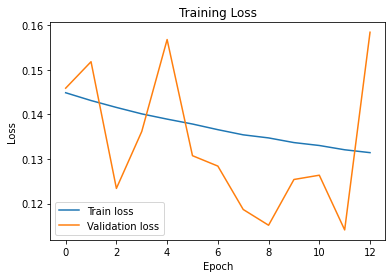

+ Train	 epoch: 14/20	 batch: 500/5373	 loss: 0.1384720802307129
+ Train	 epoch: 14/20	 batch: 1000/5373	 loss: 0.1261146366596222
+ Train	 epoch: 14/20	 batch: 1500/5373	 loss: 0.09316310286521912
+ Train	 epoch: 14/20	 batch: 2000/5373	 loss: 0.11091935634613037
+ Train	 epoch: 14/20	 batch: 2500/5373	 loss: 0.12222029268741608
+ Train	 epoch: 14/20	 batch: 3000/5373	 loss: 0.10647141933441162
+ Train	 epoch: 14/20	 batch: 3500/5373	 loss: 0.10184453427791595
+ Train	 epoch: 14/20	 batch: 4000/5373	 loss: 0.14435890316963196
+ Train	 epoch: 14/20	 batch: 4500/5373	 loss: 0.1505689024925232
+ Train	 epoch: 14/20	 batch: 5000/5373	 loss: 0.13043753802776337
Train	 epoch: 14/20	 loss: 0.13060031459498134
Validation	 epoch: 14/20	 loss: 0.14058764278888702
Saving model


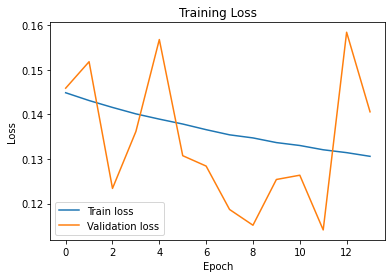

+ Train	 epoch: 15/20	 batch: 500/5373	 loss: 0.12884151935577393
+ Train	 epoch: 15/20	 batch: 1000/5373	 loss: 0.2018052041530609
+ Train	 epoch: 15/20	 batch: 1500/5373	 loss: 0.10301409661769867
+ Train	 epoch: 15/20	 batch: 2000/5373	 loss: 0.12996806204319
+ Train	 epoch: 15/20	 batch: 2500/5373	 loss: 0.12173345685005188
+ Train	 epoch: 15/20	 batch: 3000/5373	 loss: 0.1156417727470398
+ Train	 epoch: 15/20	 batch: 3500/5373	 loss: 0.12348878383636475
+ Train	 epoch: 15/20	 batch: 4000/5373	 loss: 0.12502825260162354
+ Train	 epoch: 15/20	 batch: 4500/5373	 loss: 0.13049015402793884
+ Train	 epoch: 15/20	 batch: 5000/5373	 loss: 0.1257331371307373
Train	 epoch: 15/20	 loss: 0.129870388918242
Validation	 epoch: 15/20	 loss: 0.116457998752594
Saving model


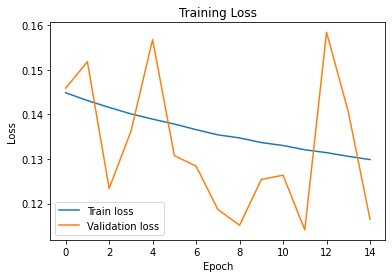

+ Train	 epoch: 16/20	 batch: 500/5373	 loss: 0.12016941606998444
+ Train	 epoch: 16/20	 batch: 1000/5373	 loss: 0.10262167453765869
+ Train	 epoch: 16/20	 batch: 1500/5373	 loss: 0.14324453473091125
+ Train	 epoch: 16/20	 batch: 2000/5373	 loss: 0.11846477538347244
+ Train	 epoch: 16/20	 batch: 2500/5373	 loss: 0.13599270582199097
+ Train	 epoch: 16/20	 batch: 3000/5373	 loss: 0.12355425953865051
+ Train	 epoch: 16/20	 batch: 3500/5373	 loss: 0.146495521068573
+ Train	 epoch: 16/20	 batch: 4000/5373	 loss: 0.14963342249393463
+ Train	 epoch: 16/20	 batch: 4500/5373	 loss: 0.11439183354377747
+ Train	 epoch: 16/20	 batch: 5000/5373	 loss: 0.10745811462402344
Train	 epoch: 16/20	 loss: 0.12906912117835953
Validation	 epoch: 16/20	 loss: 0.12987899780273438
Saving model


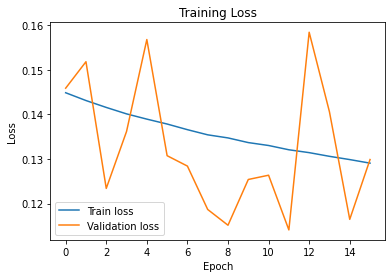

+ Train	 epoch: 17/20	 batch: 500/5373	 loss: 0.11341806501150131
+ Train	 epoch: 17/20	 batch: 1000/5373	 loss: 0.11745817959308624
+ Train	 epoch: 17/20	 batch: 1500/5373	 loss: 0.1373901665210724
+ Train	 epoch: 17/20	 batch: 2000/5373	 loss: 0.11517181992530823
+ Train	 epoch: 17/20	 batch: 2500/5373	 loss: 0.11933203786611557
+ Train	 epoch: 17/20	 batch: 3000/5373	 loss: 0.11781516671180725
+ Train	 epoch: 17/20	 batch: 3500/5373	 loss: 0.13365671038627625
+ Train	 epoch: 17/20	 batch: 4000/5373	 loss: 0.13920672237873077
+ Train	 epoch: 17/20	 batch: 4500/5373	 loss: 0.10681456327438354
+ Train	 epoch: 17/20	 batch: 5000/5373	 loss: 0.14062198996543884
Train	 epoch: 17/20	 loss: 0.12858945906589356
Validation	 epoch: 17/20	 loss: 0.13206888735294342
Saving model


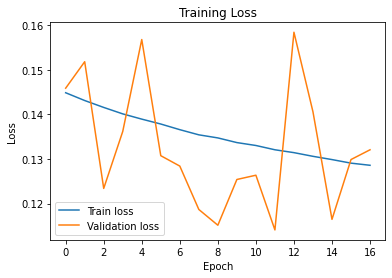

+ Train	 epoch: 18/20	 batch: 500/5373	 loss: 0.11187224090099335
+ Train	 epoch: 18/20	 batch: 1000/5373	 loss: 0.16139069199562073
+ Train	 epoch: 18/20	 batch: 1500/5373	 loss: 0.11298613250255585
+ Train	 epoch: 18/20	 batch: 2000/5373	 loss: 0.13107292354106903
+ Train	 epoch: 18/20	 batch: 2500/5373	 loss: 0.14643068611621857
+ Train	 epoch: 18/20	 batch: 3000/5373	 loss: 0.12448552250862122
+ Train	 epoch: 18/20	 batch: 3500/5373	 loss: 0.11814188212156296
+ Train	 epoch: 18/20	 batch: 4000/5373	 loss: 0.09893188625574112
+ Train	 epoch: 18/20	 batch: 4500/5373	 loss: 0.13990020751953125
+ Train	 epoch: 18/20	 batch: 5000/5373	 loss: 0.1244255006313324
Train	 epoch: 18/20	 loss: 0.1279375472593281
Validation	 epoch: 18/20	 loss: 0.1344836801290512
Saving model


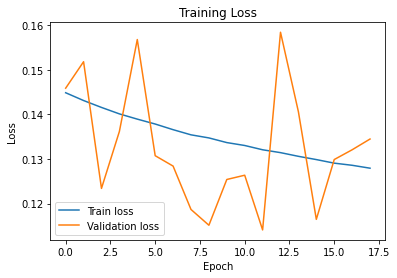

+ Train	 epoch: 19/20	 batch: 500/5373	 loss: 0.10330604761838913
+ Train	 epoch: 19/20	 batch: 1000/5373	 loss: 0.12978199124336243
+ Train	 epoch: 19/20	 batch: 1500/5373	 loss: 0.10288752615451813
+ Train	 epoch: 19/20	 batch: 2000/5373	 loss: 0.11040781438350677
+ Train	 epoch: 19/20	 batch: 2500/5373	 loss: 0.1325618028640747
+ Train	 epoch: 19/20	 batch: 3000/5373	 loss: 0.11525041610002518
+ Train	 epoch: 19/20	 batch: 3500/5373	 loss: 0.12045425921678543
+ Train	 epoch: 19/20	 batch: 4000/5373	 loss: 0.14681142568588257
+ Train	 epoch: 19/20	 batch: 4500/5373	 loss: 0.14584946632385254
+ Train	 epoch: 19/20	 batch: 5000/5373	 loss: 0.13523393869400024
Train	 epoch: 19/20	 loss: 0.12731048233339778
Validation	 epoch: 19/20	 loss: 0.11400139331817627
Saving model


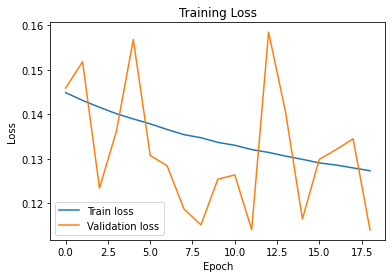

+ Train	 epoch: 20/20	 batch: 500/5373	 loss: 0.17135512828826904
+ Train	 epoch: 20/20	 batch: 1000/5373	 loss: 0.12408944964408875
+ Train	 epoch: 20/20	 batch: 1500/5373	 loss: 0.12618640065193176
+ Train	 epoch: 20/20	 batch: 2000/5373	 loss: 0.1052914559841156
+ Train	 epoch: 20/20	 batch: 2500/5373	 loss: 0.12275151908397675
+ Train	 epoch: 20/20	 batch: 3000/5373	 loss: 0.12362466752529144
+ Train	 epoch: 20/20	 batch: 3500/5373	 loss: 0.12377078831195831
+ Train	 epoch: 20/20	 batch: 4000/5373	 loss: 0.09797437489032745
+ Train	 epoch: 20/20	 batch: 4500/5373	 loss: 0.15773619711399078
+ Train	 epoch: 20/20	 batch: 5000/5373	 loss: 0.09059825539588928
Train	 epoch: 20/20	 loss: 0.1267131409766775
Validation	 epoch: 20/20	 loss: 0.1344183385372162
Saving model


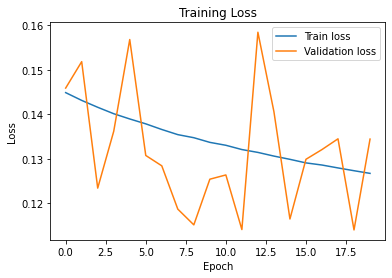

In [16]:
if ph3_saved:
  savePath = savePath_base+"TTNet_Phase3_4.pth"
  print("Loading model from path: ")
  print(savePath)
  checkpoint = torch.load(savePath)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
  start_epoch = checkpoint['cur_epoch']
  ph3_train_loss_log = checkpoint['train_loss_log']
  ph3_val_loss_log = checkpoint['val_loss_log']
  print(f"Load phase 3 at epoch {start_epoch} succeed")
else:
  checkpoint = torch.load(savePath_base+"TTNet_Phase2_30.pth")
  pretrained_dict = checkpoint['model']
  model_state_dict = model.state_dict()
  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_state_dict}
  model_state_dict.update(pretrained_dict)
  model.load_state_dict(model_state_dict,strict=False)

  #local_epoch = checkpoint['local_epoch']
  #decoder_epoch = checkpoint['decoder_epoch']
  #train_loss_log = checkpoint['train_loss_log']
  #val_loss_log = checkpoint['val_loss_log']
  #local_train_loss_log = checkpoint['local_train_loss_log']
  #local_val_loss_log = checkpoint['local_val_loss_log']

  start_epoch = 0
  print("Phase 3: No model to load, start to train at epoch 0")

print('START TO TRAIN PHASE 3: All Stages ...')

for epoch in range(start_epoch+1, ph3_epochs+1):
  model.train()
  batch_num = len(train_loader)
  train_loss = 0
  train_loss_total = 0

  for i, data_batch in enumerate(train_loader):
    optimizer.zero_grad()

    # Read in train batch
    window_imgs, xy_downscale, _, event_probs = data_batch
    window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)
    
    # TODO Why are we decomposing and then recomposing into a diff form?
    # Can't we just do a straight conversion
    ball_x,ball_y = xy_downscale
    xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

    # Model forward step
    with autocast():
      gloabl_out, local_out, _, crop_params, event_out = model(window_batch)
    
    # Get event probs and local xy predictions
    event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
    local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
    local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

    # Calucate train (global+local+event) loss
    with autocast():
      global_loss_train = ball_loss(gloabl_out,xy_downscale_batch) * global_weight
      local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
      event_loss_train = event_loss(event_out,event_probs) * event_weight
      train_loss = global_loss_train + local_loss_train + event_loss_train

    scaler.scale(train_loss).backward()
    loss = train_loss.detach().cpu().numpy()
    train_loss_total += loss

    if((i+1)%500==0):
      print(f"+ Train\t epoch: {epoch}/{ph3_epochs}\t batch: {i+1}/{batch_num}\t loss: {loss}")
    
    scaler.step(optimizer)
    scaler.update()

    #train_loss.backward()
    #optimizer.step()
    #train_loss_total += train_loss.item()

  # Log trainig losses
  print(f"Train\t epoch: {epoch}/{ph3_epochs}\t loss: {train_loss_total/batch_num}")
  ph3_train_loss_log.append(train_loss_total/batch_num)


  model.eval()
  with torch.no_grad():   
    batch_num = len(val_loader)
    val_loss = 0
    val_loss_total = 0
    for i, data_batch in enumerate(val_loader):
      # Read in val batch
      window_imgs, xy_downscale, _, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # TODO Why are we decomposing and then recomposing into a diff form?
      # Can't we just do a straight conversion
      ball_x,ball_y = xy_downscale
      xy_downscale_batch = torch.stack((ball_x,ball_y)).transpose(0,1)

      # Model forward step
      with autocast():
        global_out, local_out, _, crop_params, event_out = model(window_batch)

      # Get event probs and local xy predictions
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)
      local_ball_xy = get_local_groundtruth(xy_downscale,crop_params)
      local_ball_xy = torch.as_tensor(local_ball_xy,dtype=torch.float32).to(device)

      # Calucate val (global+local+event) loss
      with autocast():
        global_loss_train = ball_loss(global_out,xy_downscale_batch) * global_weight
        local_loss_train = ball_loss(local_out,local_ball_xy) * local_weight
        event_loss_train = event_loss(event_out,event_probs) * event_weight
        val_loss = global_loss_train + local_loss_train + event_loss_train
      
      loss = train_loss.detach().cpu().numpy()
      val_loss_total += loss

    ph3_val_loss_log.append(val_loss_total/batch_num)
    print(f"Validation\t epoch: {epoch}/{ph3_epochs}\t loss: {val_loss_total/batch_num}")

  print("Saving model")
  savePath = savePath_base+f"TTNet_Phase3_{epoch}.pth"
  state = {'model':model.state_dict(),'optimizer':optimizer.state_dict(),'lr_scheduler':lr_scheduler.state_dict(),'cur_epoch':epoch,'train_loss_log':ph3_train_loss_log,'val_loss_log':ph3_val_loss_log}
  torch.save(state, savePath) 
  ph3_saved = True

  # Plot the losses
  plt.clf()
  plt.plot(range(epoch),ph3_train_loss_log,label='Train loss')
  plt.plot(range(epoch),ph3_val_loss_log,label='Validation loss')
  plt.legend()
  #plt.xticks(range(epoch), range(1,31))
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss')
  plt.savefig(outputPath+"loss_ph3.png")
  plt.show()

## Testing

In [13]:
tasks = ["local", "event"]
model = TTNet(dropout_p=0.5, frame_window=9, threshold=0.01, tasks=tasks).to(device)
savePath = savePath_base+"Final/TTNet_Phase3_20.pth"
checkpoint = torch.load(savePath)
model.load_state_dict(checkpoint['model'])
window_imgs, xy_downscale, window_centre, event_probs = next(iter(train_loader))  

In [43]:
def save_predict(outputPath_e):
  model.eval()
  with torch.no_grad():   
    event_counter = 0
    for i,data_batch in enumerate(tqdm(test_loader)):
      # Read in test bacth
      window_imgs, xy_downscale, window_centre, event_probs = data_batch
      window_batch = torch.as_tensor(window_imgs,dtype=torch.float32).to(device, non_blocking=True)

      # Model forward step
      global_out, local_out, local_in, crop_params, event_out = model(window_batch)
      event_probs = torch.as_tensor(event_probs,dtype=torch.float32).to(device, non_blocking=True)

      local_out_clone = local_out.clone().detach()
      global_out_clone = global_out.clone().detach()
      event_out_clone = event_out.clone().detach()

      for out_index in range(local_out_clone.shape[0]):  
        pre_event = event_out_clone[out_index]
        ground_event = event_probs[out_index]
        local_output_clone_x = local_out_clone[out_index,:TTN_width]
        local_output_clone_y = local_out_clone[out_index,TTN_width:]

        local_output_x = torch.argmax(local_output_clone_x).item()
        local_output_y = torch.argmax(local_output_clone_y).item()

        global_output_clone_x = global_out_clone[out_index,:TTN_width]
        global_output_clone_y = global_out_clone[out_index,TTN_width:]

        global_output_x = torch.argmax(global_output_clone_x).item()
        global_output_y = torch.argmax(global_output_clone_y).item()

        pred_x = global_output_x*data_width/TTN_width-TTN_width/2+local_output_x
        pred_y = global_output_y*data_height/TTN_height-TTN_height/2+local_output_y

        pred_x = 0 if pred_x<0 else pred_x
        pred_y = 0 if pred_y<0 else pred_y

        ori_x = xy_downscale[0][out_index].item()*(data_width/TTN_width)
        ori_y = xy_downscale[1][out_index].item()*(data_height/TTN_height)
        #print("------")

        #print("Global:\t X: "+str(global_output_x*data_width/TTN_width)+"\t Y:"+str(global_output_y*data_height/TTN_height))
        #print("Local:\t X: "+str(local_output_x*data_width/TTN_width)+"\t Y:"+str(local_output_y*data_height/TTN_height))
        #print("Pred:\t X: "+str(pred_x)+"\t Y:"+str(pred_y))
        #print("Real:\t X: "+str(ori_x)+"\t\t Y:"+str(ori_y))
        ori_image = cv.imread(window_centre[out_index])
        cv.imwrite(  outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Input.jpg" , ori_image )

        vutils.save_image(local_in[out_index][24:], outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Crop_Img.jpg")
        
        cv.circle(ori_image, (int(pred_x),int(pred_y)), 8,  (0, 0, 255), 2)
        cv.circle(ori_image, (int(ori_x),int(ori_y)), 8,  (0, 255, 0), 2)

        if(pre_event[0].item()>=0.9):
          event_text = "Event: Not in image"
          cv.putText(ori_image, event_text, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

        if(pre_event[1].item()>=0.8):
          event_text = "Event: Flying"
          cv.putText(ori_image, event_text, (50, 100), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        if(pre_event[2].item()>=0.8):
          event_text = "Event: Bouncing"
          cv.putText(ori_image, event_text, (50, 150), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

        if(pre_event[3].item()>=0.8):
          event_text = "Event: Hit"
          cv.putText(ori_image, event_text, (50, 200), cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)

        if(pre_event[4].item()>=0.8):
          event_text = "Event: Net Contact"
          cv.putText(ori_image, event_text, (50, 250), cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

        if((pre_event[1].item()>=0.5 and ground_event[1].item()>=0.5) or
          (pre_event[2].item()>=0.5 and ground_event[2].item()>=0.5) or
          (pre_event[3].item()>=0.5 and ground_event[3].item()>=0.5) or
          (pre_event[4].item()>=0.5 and ground_event[4].item()>=0.5)):
          event_counter+=1

        ball_detected,x_min,y_min,x_max,y_max,padding_x,padding_y = crop_params[out_index]
        cv.rectangle(ori_image, (x_min,y_min), (x_max,y_max), (0,0,255), 2)

        cv.imwrite(outputPath_e+f"{(i*local_out_clone.shape[0]+out_index):04d}"+"_Ori_Img.jpg" , ori_image )

        # Concat image
        cat_img_1 = cv.imread(outputPath_e+f"{(i*local_out_clone.shape[0]+out_index):04d}"+"_Ori_Img.jpg")
        cat_img_1 = cv.resize(cat_img_1, ( data_width , data_height ))

        cat_img_2 = cv.imread(outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_Crop_Img.jpg")
        cat_img_2 = cv.resize(cat_img_2, ( data_width , data_height ))

        cat_h_1=cv.hconcat([cat_img_1,cat_img_2])
        cv.imwrite(outputPath_e+str(i*local_out_clone.shape[0]+out_index)+"_cat.jpg" , cat_h_1 )

In [44]:
outputPath_e = outputPath+"Predictions/"
folder = os.path.exists(outputPath_e)
if not folder: 
  os.makedirs(outputPath_e)
save_predict(outputPath_e)

100%|██████████| 671/671 [16:23<00:00,  1.47s/it]
